# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading Data

In [2]:
df=pd.read_csv('features_data.csv')
df['Label'] = df['Label'].replace({0: 'Tr.B', 1: 'IoT.M', 2: 'IoT.M', 3: 'IoT.M', 4: 'IoT.B', 5: 'Tr.M'})

In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df1=df[:1000000]
# Shuffle the DataFrame

# Filter only benign data for training
benign_df = df1[df1['Label'].isin(['Tr.B', 'IoT.B'])]
malicious_df = df1[df1['Label'].isin(['Tr.M', 'IoT.M'])]

In [4]:
import pandas as pd

# Ensure the "Label" column is a string type before filtering
df1["Label"] = df1["Label"].astype(str)

# Extract benign traffic (IoT.B and Tr.B)
benign_df = df1[df1["Label"].isin(["IoT.B", "Tr.B"])]

# Extract a small portion of benign data for testing (e.g., 20%)
benign_test_df = benign_df.sample(frac=0.2, random_state=42)  # Adjust frac as needed

# Remaining benign data for training
benign_train_df = benign_df.drop(benign_test_df.index)

# Extract all malicious traffic (Tr.M and IoT.M) for testing
malicious_test_df = df1[df1["Label"].isin(["Tr.M", "IoT.M"])]

# Combine test set (benign + malicious)
test_df = pd.concat([benign_test_df, malicious_test_df])

# Convert categorical labels to numerical values
df1["Label"] = df1["Label"].replace({'Tr.B': 0, 'IoT.B': 0, 'Tr.M': 1, 'IoT.M': 1})

# Apply the same numerical mapping to train and test sets
train_df = benign_train_df.replace({'Tr.B': 0, 'IoT.B': 0, 'Tr.M': 1, 'IoT.M': 1})
test_df = test_df.replace({'Tr.B': 0, 'IoT.B': 0, 'Tr.M': 1, 'IoT.M': 1})

# Display dataset sizes
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)


Training Data Shape: (593623, 39)
Testing Data Shape: (406377, 39)


In [5]:
from collections import Counter
Counter(train_df['Label'])

Counter({0: 593623})

In [6]:
from collections import Counter
Counter(test_df['Label'])

Counter({1: 257971, 0: 148406})

### For anomaly detection, we only need genuine class of the data

Since we want the model to only learn and fit on normal data, we only use the `genuine` class. This is to ensure that when an abnormal input is given to the model, its reconstruction error will be higher than that of a normal input. For testing of the model, samples from both the classes will be used.

In [7]:
X = train_df.drop(['Label'], axis=1)
y = train_df['Label']

X1 = test_df.drop(['Label'], axis=1)
y_test = test_df['Label']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X1)



print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (593623, 38)
Testing Data Shape: (406377, 38)


In [8]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [11]:
import time
import psutil
import os
import tensorflow as tf

# Set up your training data (example)
# X_train, X_test should be defined before this step

# Function to track resource usage
def track_resources():
    # Get the current process ID
    process = psutil.Process(os.getpid())
    
    # Get CPU usage as a percentage
    cpu_usage = process.cpu_percent(interval=1)  # CPU percentage for the last second
    
    # Get memory usage in MB
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    
    return cpu_usage, memory_usage

# Define a custom callback to track resource usage during training
class ResourceTrackingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        cpu, memory = track_resources()
        # Display CPU and Memory usage rounded to 5 decimal places
        print(f"Epoch {epoch+1}: CPU Usage: {cpu:.5f}% | Memory Usage: {memory:.5f} MB")
        cpuusage.append(cpu)
        memoryusage.append(memory)
        

# Update the track_resources function
def track_resources():
    # Get the current process ID
    process = psutil.Process(os.getpid())
    
    # Get CPU usage as a percentage, increasing interval for better accuracy
    cpu_usage = psutil.cpu_percent(interval=2)  # Set a longer interval
    
    # Get memory usage in MB
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    
    return cpu_usage, memory_usage

# DNN Model Building - Autoencoder

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

cpuusage=[]
memoryusage=[]
# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = input_dim // 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(encoding_dim // 2, activation="relu")(encoded)

decoded = Dense(encoding_dim // 2, activation="relu")(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer="adam", loss="mse")


# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")

Epoch 1/100
Epoch 1: CPU Usage: 42.10000% | Memory Usage: 10256.23438 MB
4638/4638 - 17s - 4ms/step - loss: 0.0223 - val_loss: 0.2683
Epoch 2/100
Epoch 2: CPU Usage: 28.80000% | Memory Usage: 10264.64453 MB
4638/4638 - 12s - 3ms/step - loss: 0.0079 - val_loss: 0.2524
Epoch 3/100
Epoch 3: CPU Usage: 36.00000% | Memory Usage: 10265.35156 MB
4638/4638 - 13s - 3ms/step - loss: 0.0066 - val_loss: 0.2536
Epoch 4/100
Epoch 4: CPU Usage: 40.80000% | Memory Usage: 10265.51172 MB
4638/4638 - 12s - 3ms/step - loss: 0.0059 - val_loss: 0.2511
Epoch 5/100
Epoch 5: CPU Usage: 28.60000% | Memory Usage: 10265.57422 MB
4638/4638 - 12s - 3ms/step - loss: 0.0056 - val_loss: 0.2492
Epoch 6/100
Epoch 6: CPU Usage: 29.70000% | Memory Usage: 10265.77344 MB
4638/4638 - 12s - 3ms/step - loss: 0.0054 - val_loss: 0.2526
Epoch 7/100
Epoch 7: CPU Usage: 31.40000% | Memory Usage: 10265.79297 MB
4638/4638 - 12s - 3ms/step - loss: 0.0053 - val_loss: 0.2487
Epoch 8/100
Epoch 8: CPU Usage: 34.10000% | Memory Usage: 1026

In [20]:
autoencoder.save("DNN_MEn.h5")  # Saves in TensorFlow's native format

In [1]:
cpu=[42.1, 28.8, 36.0, 40.8, 28.6, 29.7, 31.4, 34.1, 37.5, 45.0, 37.4, 44.0, 34.3, 42.8, 51.1, 47.6, 46.7, 42.8, 32.8, 46.4, 31.0, 38.6, 29.7, 32.8, 70.3, 43.6, 24.4, 19.4, 12.6, 26.5, 11.4, 22.2, 16.2, 18.4, 20.9, 20.5, 19.1, 21.9, 17.3, 12.9, 16.9, 14.1, 18.6, 23.1, 19.5, 22.1, 21.5, 14.9, 22.2, 15.5, 13.6, 21.7, 27.6, 15.5, 18.0, 29.8, 17.6, 25.7, 26.2, 17.3, 12.3, 20.1, 13.6, 17.6, 18.2, 16.2, 11.0, 17.4, 17.2, 15.5, 23.2, 25.8, 22.4, 18.9, 21.1, 23.5, 14.3, 13.8, 19.7, 13.0, 15.4, 24.4, 21.8, 18.7, 10.2, 16.7, 9.4, 8.8, 4.1, 20.5, 9.7, 47.2, 18.0, 24.1, 19.8, 19.8, 16.2, 19.8, 20.3, 24.3]
mu=[10256.234375, 10264.64453125, 10265.3515625, 10265.51171875, 10265.57421875, 10265.7734375, 10265.79296875, 10265.83203125, 10266.109375, 10266.29296875, 10266.34375, 10266.52734375, 10266.65234375, 10266.66015625, 10266.82421875, 10266.99609375, 10267.16796875, 10267.23828125, 10267.56640625, 10267.71875, 10267.7890625, 10268.1640625, 10268.3671875, 10268.37890625, 10268.44921875, 10268.45703125, 10268.45703125, 10268.48046875, 10268.55078125, 10268.5546875, 10268.64453125, 10268.64453125, 10268.78125, 10268.7890625, 10268.78515625, 10268.80078125, 10268.8125, 10268.8203125, 10268.828125, 10268.828125, 10268.83203125, 10268.828125, 10268.84765625, 10268.84375, 10268.8515625, 10268.859375, 10268.84765625, 10268.8671875, 10268.87890625, 10268.87890625, 10268.8828125, 10268.8828125, 10268.89453125, 10268.89453125, 10268.90234375, 10268.91796875, 10268.91015625, 10268.91796875, 10268.921875, 10268.921875, 10268.92578125, 10268.93359375, 10268.9375, 10268.93359375, 10268.92578125, 10268.94921875, 10268.953125, 10268.95703125, 10268.97265625, 10268.96875, 10268.98046875, 10268.9765625, 10268.97265625, 10268.98046875, 10268.984375, 10269.1015625, 10269.09765625, 10269.1015625, 10269.25390625, 10269.25, 10269.24609375, 10269.2578125, 10269.3359375, 10269.34765625, 10269.34375, 10269.3515625, 10269.34765625, 10269.3515625, 10269.359375, 10269.3515625, 10269.35546875, 10269.34375, 10269.35546875, 10269.359375, 10269.37109375, 10269.375, 10269.375, 10269.37109375, 10269.38671875, 10269.38671875]
loss=[0.022327573969960213, 0.007859546691179276, 0.00660377973690629, 0.005937253590673208, 0.005557590164244175, 0.0054083168506622314, 0.0053413910791277885, 0.005308812018483877, 0.005215686745941639, 0.005129816010594368, 0.005064716562628746, 0.005030399654060602, 0.005020506214350462, 0.00499358493834734, 0.004985685460269451, 0.004968829918652773, 0.004973546136170626, 0.00496888579800725, 0.004961627069860697, 0.00493977963924408, 0.004933930933475494, 0.004929612390697002, 0.004928857088088989, 0.004917829763144255, 0.00492137111723423, 0.004902855958789587, 0.0049127680249512196, 0.004920621868222952, 0.0049041504971683025, 0.004908548202365637, 0.00491674430668354, 0.004910335410386324, 0.004898958373814821, 0.004902003798633814, 0.0049115680158138275, 0.0048906318843364716, 0.004893760662525892, 0.00490177795290947, 0.0048900991678237915, 0.004881464876234531, 0.004884875379502773, 0.0048899478279054165, 0.0048832460306584835, 0.0048899841494858265, 0.004906774032860994, 0.004880197811871767, 0.00488537922501564, 0.004884155001491308, 0.004876211751252413, 0.004881284199655056, 0.004886083770543337, 0.004890557378530502, 0.004877860192209482, 0.004874196369200945, 0.004893321543931961, 0.004881047178059816, 0.0048953755758702755, 0.004877646919339895, 0.004893092904239893, 0.004881167784333229, 0.004875496029853821, 0.004863577429205179, 0.004876758903264999, 0.004857320338487625, 0.004872170742601156, 0.004878030624240637, 0.004865713883191347, 0.004871211014688015, 0.004869934171438217, 0.0048857140354812145, 0.0048820325173437595, 0.0048610251396894455, 0.004882140085101128, 0.0048841326497495174, 0.004879591520875692, 0.004877300001680851, 0.004859325475990772, 0.004866606090217829, 0.004869169555604458, 0.0048513817600905895, 0.004854122176766396, 0.0048522441647946835, 0.00485145952552557, 0.004864530637860298, 0.004872438497841358, 0.00486226100474596, 0.004835813771933317, 0.0048782736994326115, 0.004855375736951828, 0.004864346701651812, 0.004878285340964794, 0.004860468674451113, 0.00486326590180397, 0.004855518229305744, 0.004842186812311411, 0.004854896105825901, 0.004854109603911638, 0.0048581273294985294, 0.004845344461500645, 0.004847402684390545]
vl=[0.2682868540287018, 0.2524022161960602, 0.25359925627708435, 0.2511175870895386, 0.2492184191942215, 0.2526387572288513, 0.24868446588516235, 0.2487805336713791, 0.24864931404590607, 0.2478286176919937, 0.24830736219882965, 0.24913260340690613, 0.25314149260520935, 0.2452627718448639, 0.24699249863624573, 0.24469296634197235, 0.24654418230056763, 0.24452431499958038, 0.25204724073410034, 0.24563421308994293, 0.24341213703155518, 0.24545426666736603, 0.24243231117725372, 0.24253718554973602, 0.2450447976589203, 0.2427271008491516, 0.24289916455745697, 0.250500351190567, 0.24175038933753967, 0.24395662546157837, 0.2420373111963272, 0.2406918704509735, 0.24159331619739532, 0.24062171578407288, 0.24024464190006256, 0.24872320890426636, 0.2449054718017578, 0.2451331615447998, 0.2442583292722702, 0.24446630477905273, 0.24017348885536194, 0.24085618555545807, 0.24406760931015015, 0.24103547632694244, 0.24147826433181763, 0.24142520129680634, 0.24177443981170654, 0.24654263257980347, 0.2432895004749298, 0.24138763546943665, 0.24239934980869293, 0.24489282071590424, 0.24449537694454193, 0.24204695224761963, 0.2406887412071228, 0.24217277765274048, 0.24035674333572388, 0.2433517575263977, 0.24087578058242798, 0.24318061769008636, 0.24217253923416138, 0.24415592849254608, 0.244789257645607, 0.23990696668624878, 0.24085964262485504, 0.2430688589811325, 0.24684487283229828, 0.24142509698867798, 0.24121907353401184, 0.24107378721237183, 0.24207599461078644, 0.24294248223304749, 0.2405543029308319, 0.24156440794467926, 0.24271568655967712, 0.24075861275196075, 0.24266473948955536, 0.24172839522361755, 0.2405083179473877, 0.24276942014694214, 0.24033084511756897, 0.24049949645996094, 0.24052131175994873, 0.24085094034671783, 0.24045835435390472, 0.24169856309890747, 0.2417956441640854, 0.2418246567249298, 0.23988957703113556, 0.24189108610153198, 0.2407798022031784, 0.24163635075092316, 0.24150478839874268, 0.2405998557806015, 0.2404293566942215, 0.24064397811889648, 0.24116574227809906, 0.2402001917362213, 0.24024924635887146, 0.2429720014333725]

[42.1, 28.8, 36.0, 40.8, 28.6, 29.7, 31.4, 34.1, 37.5, 45.0, 37.4, 44.0, 34.3, 42.8, 51.1, 47.6, 46.7, 42.8, 32.8, 46.4, 31.0, 38.6, 29.7, 32.8, 70.3, 43.6, 24.4, 19.4, 12.6, 26.5, 11.4, 22.2, 16.2, 18.4, 20.9, 20.5, 19.1, 21.9, 17.3, 12.9, 16.9, 14.1, 18.6, 23.1, 19.5, 22.1, 21.5, 14.9, 22.2, 15.5, 13.6, 21.7, 27.6, 15.5, 18.0, 29.8, 17.6, 25.7, 26.2, 17.3, 12.3, 20.1, 13.6, 17.6, 18.2, 16.2, 11.0, 17.4, 17.2, 15.5, 23.2, 25.8, 22.4, 18.9, 21.1, 23.5, 14.3, 13.8, 19.7, 13.0, 15.4, 24.4, 21.8, 18.7, 10.2, 16.7, 9.4, 8.8, 4.1, 20.5, 9.7, 47.2, 18.0, 24.1, 19.8, 19.8, 16.2, 19.8, 20.3, 24.3]
[10256.234375, 10264.64453125, 10265.3515625, 10265.51171875, 10265.57421875, 10265.7734375, 10265.79296875, 10265.83203125, 10266.109375, 10266.29296875, 10266.34375, 10266.52734375, 10266.65234375, 10266.66015625, 10266.82421875, 10266.99609375, 10267.16796875, 10267.23828125, 10267.56640625, 10267.71875, 10267.7890625, 10268.1640625, 10268.3671875, 10268.37890625, 10268.44921875, 10268.45703125, 1

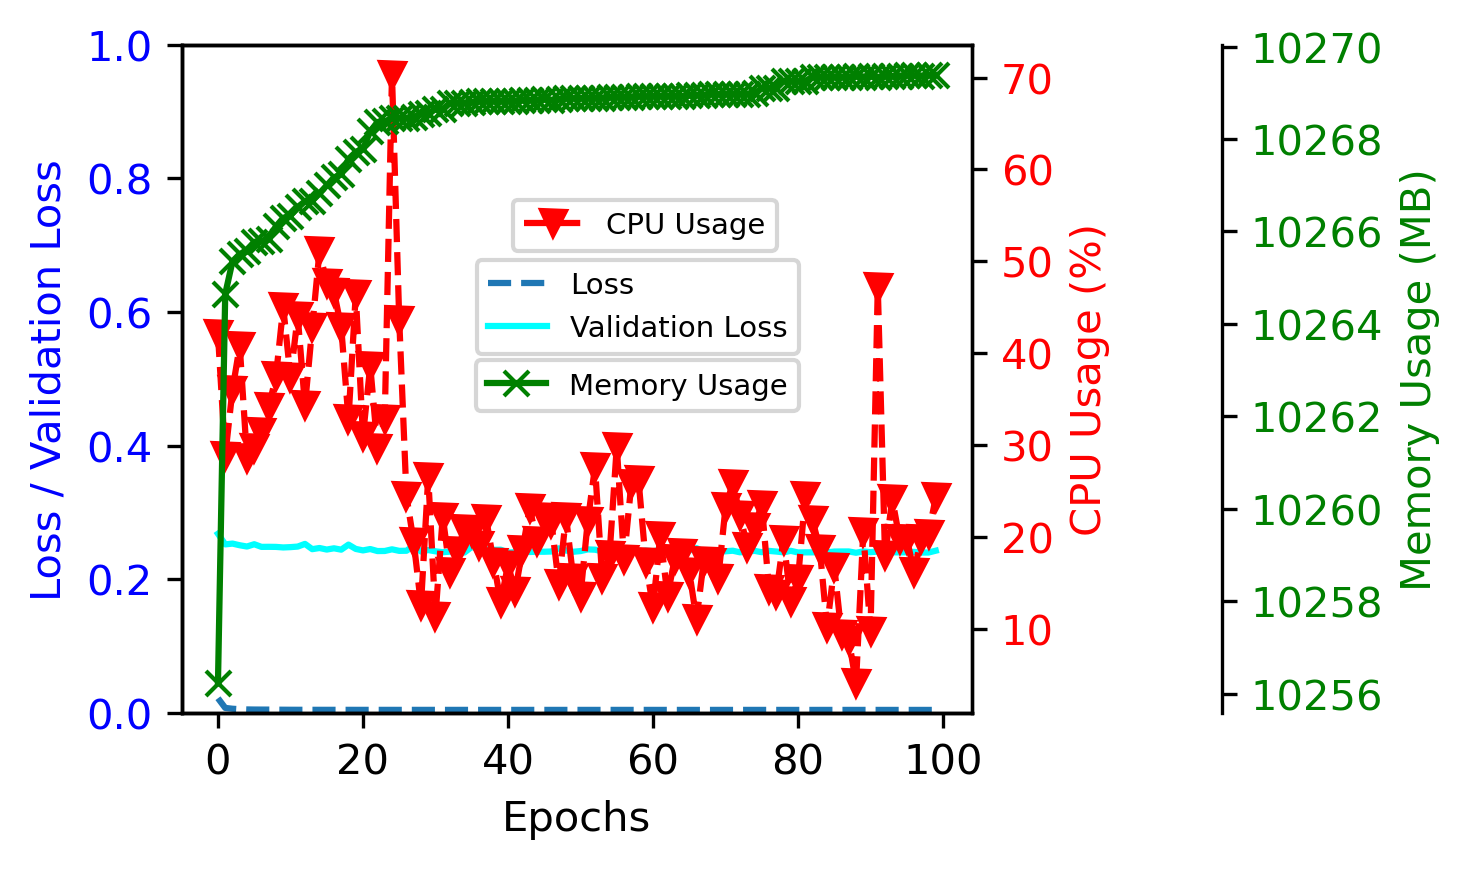

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
print(cpu)
print(mu)
print(loss)
print(vl)


fig, ax1 = plt.subplots(figsize=(5, 3),dpi=300)

# First Y-axis (Loss values)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss / Validation Loss", color='blue')
ax1.plot(loss, label="Loss", color='tab:blue', linestyle='dashed')
ax1.plot(vl, label="Validation Loss", color='cyan', linestyle='solid')
ax1.tick_params(axis='y', labelcolor='blue',labelsize = 10)
ax1.set_ylim(0,1)


# Second Y-axis (CPU Usage) on the right
ax2 = ax1.twinx()
ax2.set_ylabel("CPU Usage (%)", color='red')
ax2.plot(cpu, label="CPU Usage", color='red', linestyle='dashed', marker='v')
ax2.tick_params(axis='y', labelcolor='red',labelsize = 10)

# Third Y-axis (Memory Usage) on the right, but placed slightly shifted
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift memory usage axis to avoid overlap
ax3.set_ylabel("Memory Usage (MB)", color='Green')
ax3.plot(mu, label="Memory Usage", color='Green', linestyle='solid', marker='x')
ax3.tick_params(axis='y', labelcolor='Green',labelsize = 10)

# Legends
ax1.legend(bbox_to_anchor=(0.8, 0.7), fontsize=7)
ax2.legend(bbox_to_anchor=(0.40, 0.79), fontsize=7)
ax3.legend(bbox_to_anchor=(0.8, 0.55), fontsize=7)
plt.tight_layout()

plt.savefig('DNNMEn_allResocue.jpg')


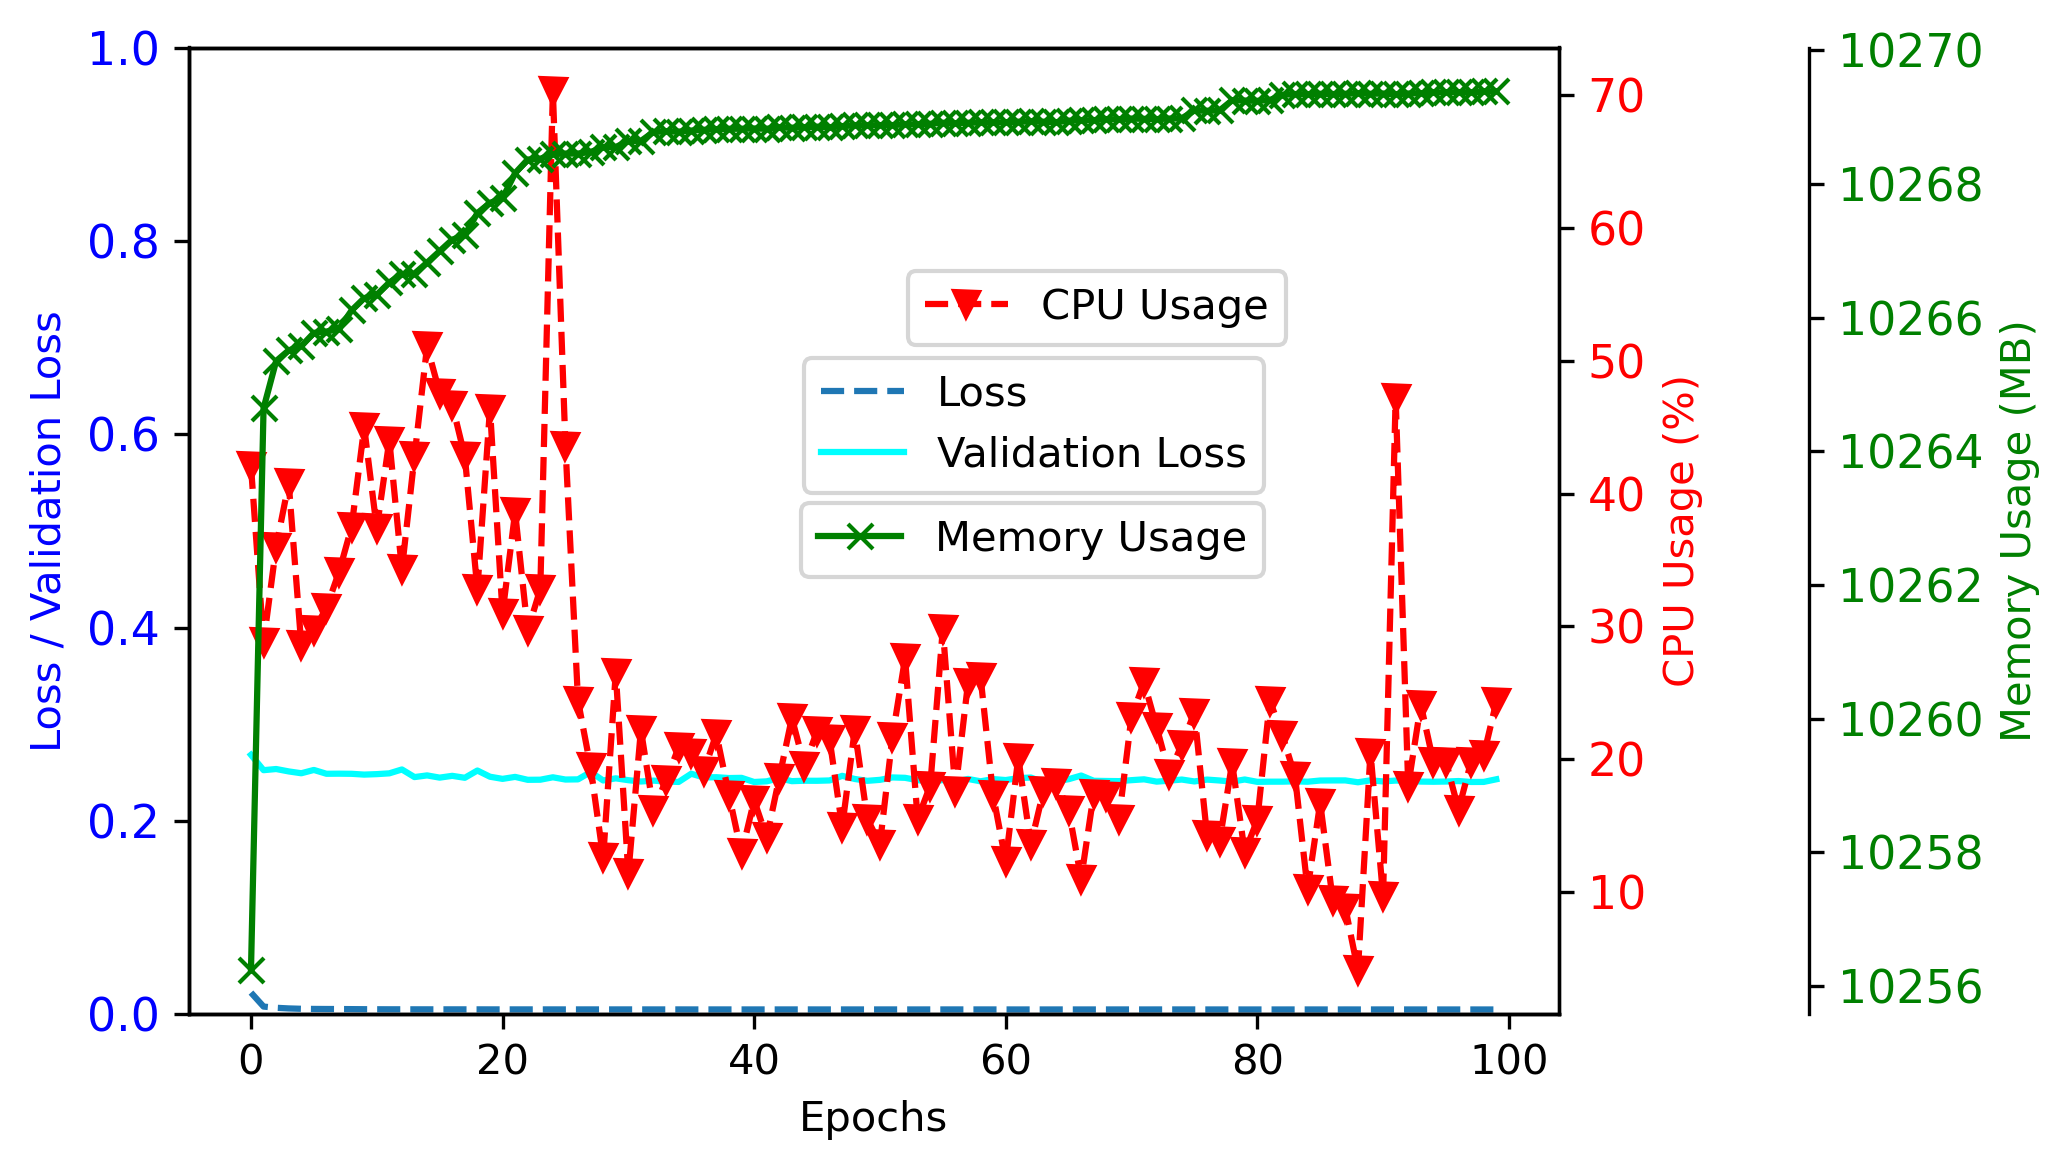

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
print(cpuusage)
print(memoryusage)
print(history.history['loss'])
print(history.history['val_loss'])


fig, ax1 = plt.subplots(figsize=(7, 4),dpi=300)

# First Y-axis (Loss values)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss / Validation Loss", color='blue')
ax1.plot(history.history['loss'], label="Loss", color='tab:blue', linestyle='dashed')
ax1.plot(history.history['val_loss'], label="Validation Loss", color='cyan', linestyle='solid')
ax1.tick_params(axis='y', labelcolor='blue',labelsize = 11)
ax1.set_ylim(0,1)


# Second Y-axis (CPU Usage) on the right
ax2 = ax1.twinx()
ax2.set_ylabel("CPU Usage (%)", color='red')
ax2.plot(cpuusage, label="CPU Usage", color='red', linestyle='dashed', marker='v')
ax2.tick_params(axis='y', labelcolor='red',labelsize = 11)

# Third Y-axis (Memory Usage) on the right, but placed slightly shifted
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift memory usage axis to avoid overlap
ax3.set_ylabel("Memory Usage (MB)", color='Green')
ax3.plot(memoryusage, label="Memory Usage", color='Green', linestyle='solid', marker='x')
ax3.tick_params(axis='y', labelcolor='Green',labelsize = 11)

# Legends
ax1.legend(bbox_to_anchor=(0.8,0.7))
ax2.legend(bbox_to_anchor=(0.51,0.79))
ax3.legend(bbox_to_anchor=(0.8,0.55))
plt.tight_layout()

plt.savefig('DNNMEn_allResocue.jpg')


reconstruction_error tf.Tensor([0.01609257 0.0091013  0.01352228 ... 0.14436386 0.15998899 0.16094133], shape=(406377,), dtype=float64)
      error  y_true
0  0.016093       0
1  0.009101       0
2  0.013522       0
3  0.045529       0
4  0.012313       0
Threshold: 0.0044	Accuracy: 0.635		Precision: 0.817	Recall Score: 0.500
Threshold: 0.0100	Accuracy: 0.734		Precision: 0.851	Recall Score: 0.636
Threshold: 0.0123	Accuracy: 0.833		Precision: 0.894	Recall Score: 0.772
Threshold: 0.0172	Accuracy: 0.933		Precision: 0.951	Recall Score: 0.908
Threshold: 0.1255	Accuracy: 0.965		Precision: 0.956	Recall Score: 0.972
Threshold: 0.1328	Accuracy: 0.865		Precision: 0.865	Recall Score: 0.894
Threshold: 0.1402	Accuracy: 0.765		Precision: 0.804	Recall Score: 0.815
Threshold: 0.1577	Accuracy: 0.665		Precision: 0.761	Recall Score: 0.736
Threshold: 0.1654	Accuracy: 0.565		Precision: 0.728	Recall Score: 0.657
Threshold: 0.2245	Accuracy: 0.465		Precision: 0.703	Recall Score: 0.579
Threshold with Maximum R

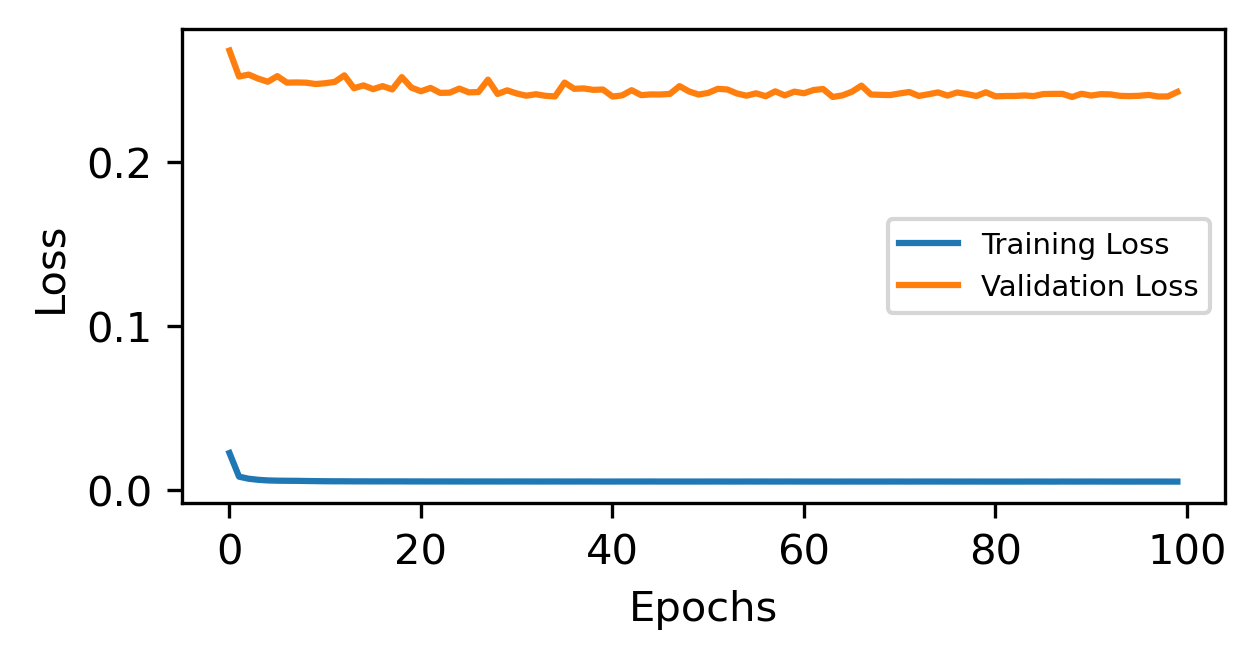

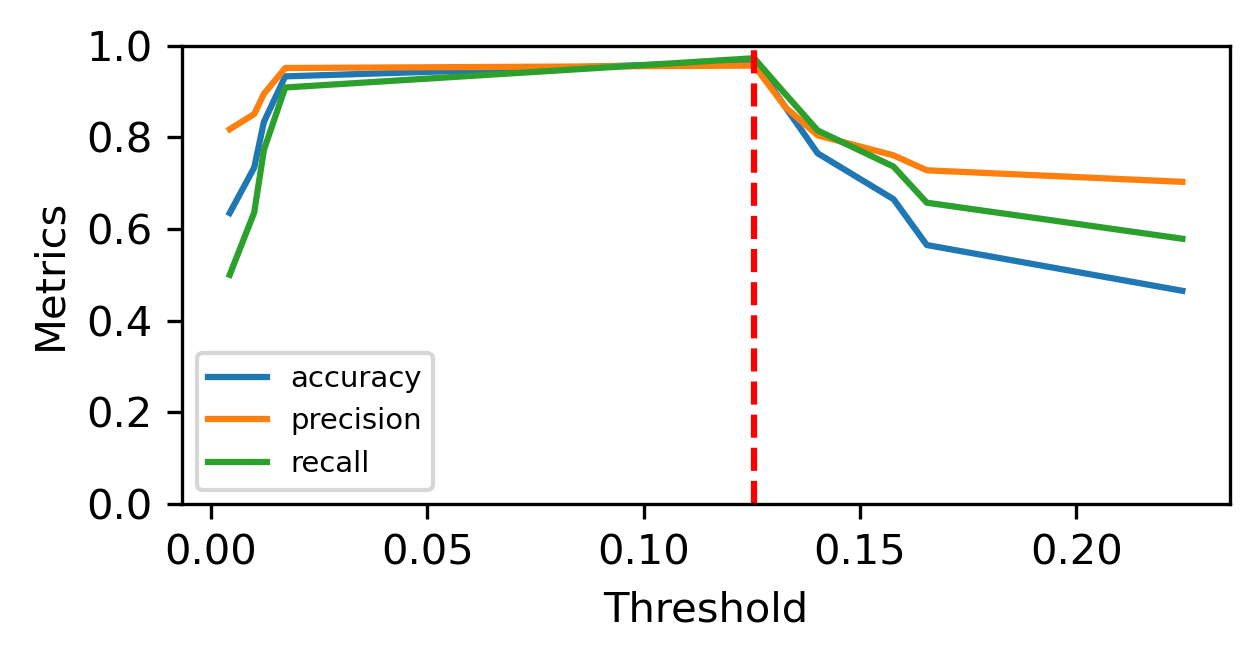

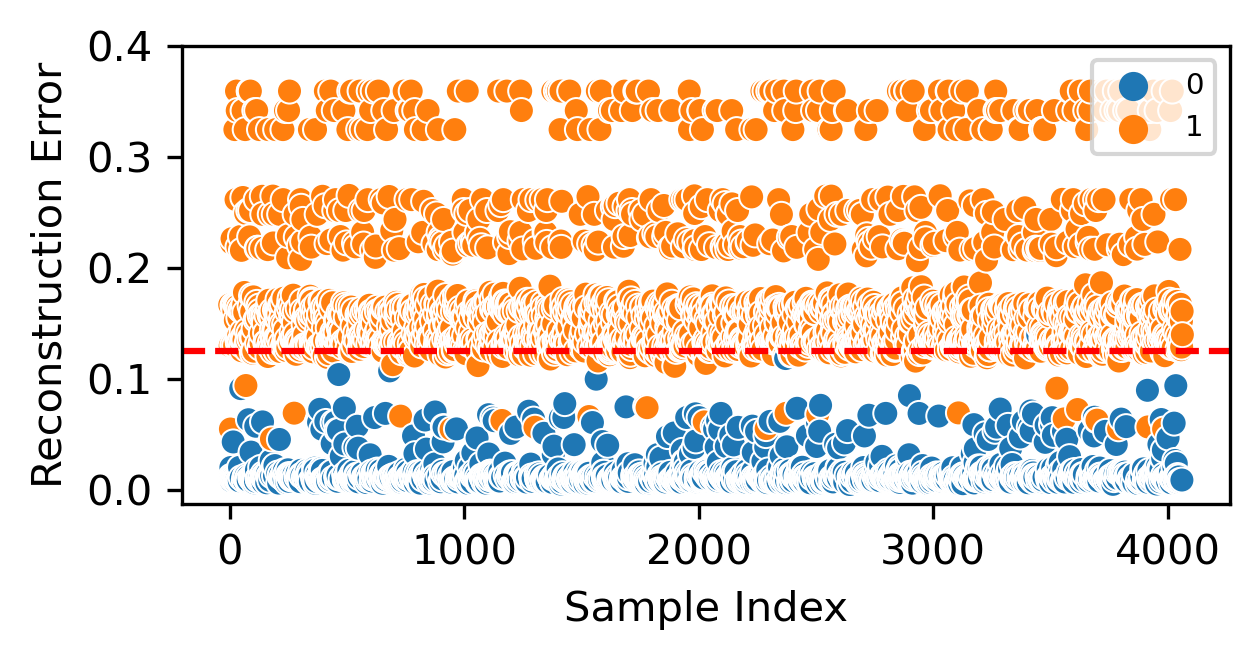

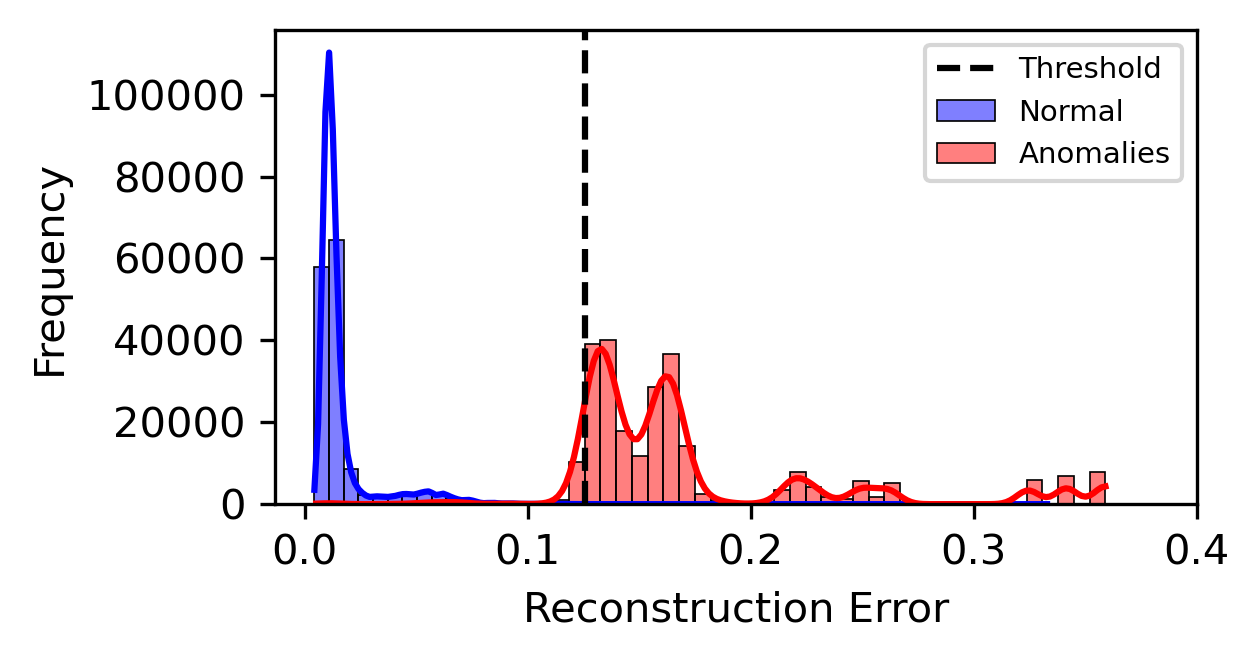

In [79]:
plt.figure(figsize=(4,2),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 7)
plt.tight_layout()
plt.tight_layout(pad=0)
plt.savefig('DNNMEn.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(4,2),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.yticks(np.arange(0, 1.2, 0.2))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('DNNMEn_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(4,2),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.yticks(np.arange(0, 0.5, 0.1))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('DNNMEn_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(4,2),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 0.5, 0.1))  # Corrected method
plt.yticks(range(0, 120000, 20000))  # Correct method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('DNNMEn_Reconst.jpg')


# 2DNN Model

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
cpuusage=[]
memoryusage=[]


# Define the Residual Autoencoder model
def build_residual_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers with residual connections
    encoded = Dense(encoding_dim, activation="relu")(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    skip_connection = Dense(encoding_dim // 2, activation="relu")(encoded)

    encoded = Dense(encoding_dim // 2, activation="relu")(skip_connection)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Decoder layers with residual connections
    decoded = Dense(encoding_dim // 2, activation="relu")(encoded)
    decoded = Add()([decoded, skip_connection])  # Adding skip connection here
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    
    return autoencoder


# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")


Epoch 1/100
Epoch 1: CPU Usage: 18.60000% | Memory Usage: 1982.96484 MB
4638/4638 - 14s - 3ms/step - loss: 0.0048 - val_loss: 0.2476
Epoch 2/100
Epoch 2: CPU Usage: 9.80000% | Memory Usage: 1986.81641 MB
4638/4638 - 36s - 8ms/step - loss: 0.0048 - val_loss: 0.2403
Epoch 3/100
Epoch 3: CPU Usage: 14.50000% | Memory Usage: 1986.93750 MB
4638/4638 - 35s - 8ms/step - loss: 0.0049 - val_loss: 0.2418
Epoch 4/100
Epoch 4: CPU Usage: 46.90000% | Memory Usage: 1987.12891 MB
4638/4638 - 15s - 3ms/step - loss: 0.0048 - val_loss: 0.2402
Epoch 5/100
Epoch 5: CPU Usage: 27.00000% | Memory Usage: 1987.16406 MB
4638/4638 - 15s - 3ms/step - loss: 0.0048 - val_loss: 0.2401
Epoch 6/100
Epoch 6: CPU Usage: 17.70000% | Memory Usage: 1987.18750 MB
4638/4638 - 19s - 4ms/step - loss: 0.0048 - val_loss: 0.2402
Epoch 7/100
Epoch 7: CPU Usage: 21.60000% | Memory Usage: 1987.23438 MB
4638/4638 - 19s - 4ms/step - loss: 0.0048 - val_loss: 0.2402
Epoch 8/100
Epoch 8: CPU Usage: 12.00000% | Memory Usage: 1987.26562 M

In [81]:
autoencoder.save("2DNN_MEn.h5")  # Saves in TensorFlow's native format

[18.6, 9.8, 14.5, 46.9, 27.0, 17.7, 21.6, 12.0, 12.8, 7.6, 20.1, 8.6, 10.2, 10.3, 10.2, 13.0, 17.7, 8.8, 16.8, 14.5, 21.2, 13.4, 7.4, 10.3, 11.6, 5.7, 17.0, 24.4, 12.7, 11.1, 9.6, 14.4, 16.4, 13.9, 9.3, 6.8, 7.8, 8.0, 5.9, 8.8, 5.0, 10.4, 13.1, 13.6, 10.2, 20.7, 10.3, 7.9, 10.4, 5.2, 7.1, 12.7, 14.0, 4.0, 9.6, 7.9, 9.3, 10.3, 21.2, 20.0, 15.1, 7.7, 8.1, 8.6, 11.5, 5.0, 6.0, 12.0, 9.6, 9.8, 5.4, 7.7, 13.6, 14.7, 11.7, 12.9, 20.3, 9.8, 8.4, 6.1, 6.2, 4.6, 7.7, 13.4, 9.9, 7.6, 10.9, 10.2, 15.0, 20.5, 15.2, 9.3, 8.5, 9.4, 7.9, 15.4, 11.8, 7.4, 11.9, 89.9]
[1982.96484375, 1986.81640625, 1986.9375, 1987.12890625, 1987.1640625, 1987.1875, 1987.234375, 1987.265625, 1987.34765625, 1987.36328125, 1833.76953125, 1833.828125, 1833.84765625, 1833.921875, 1833.93359375, 1833.99609375, 1834.01953125, 1834.015625, 1834.02734375, 1834.04296875, 1834.0390625, 1834.0390625, 1834.0390625, 1834.04296875, 1834.05859375, 1834.046875, 1834.203125, 1834.23046875, 1834.26171875, 1834.44921875, 1834.47265625, 18

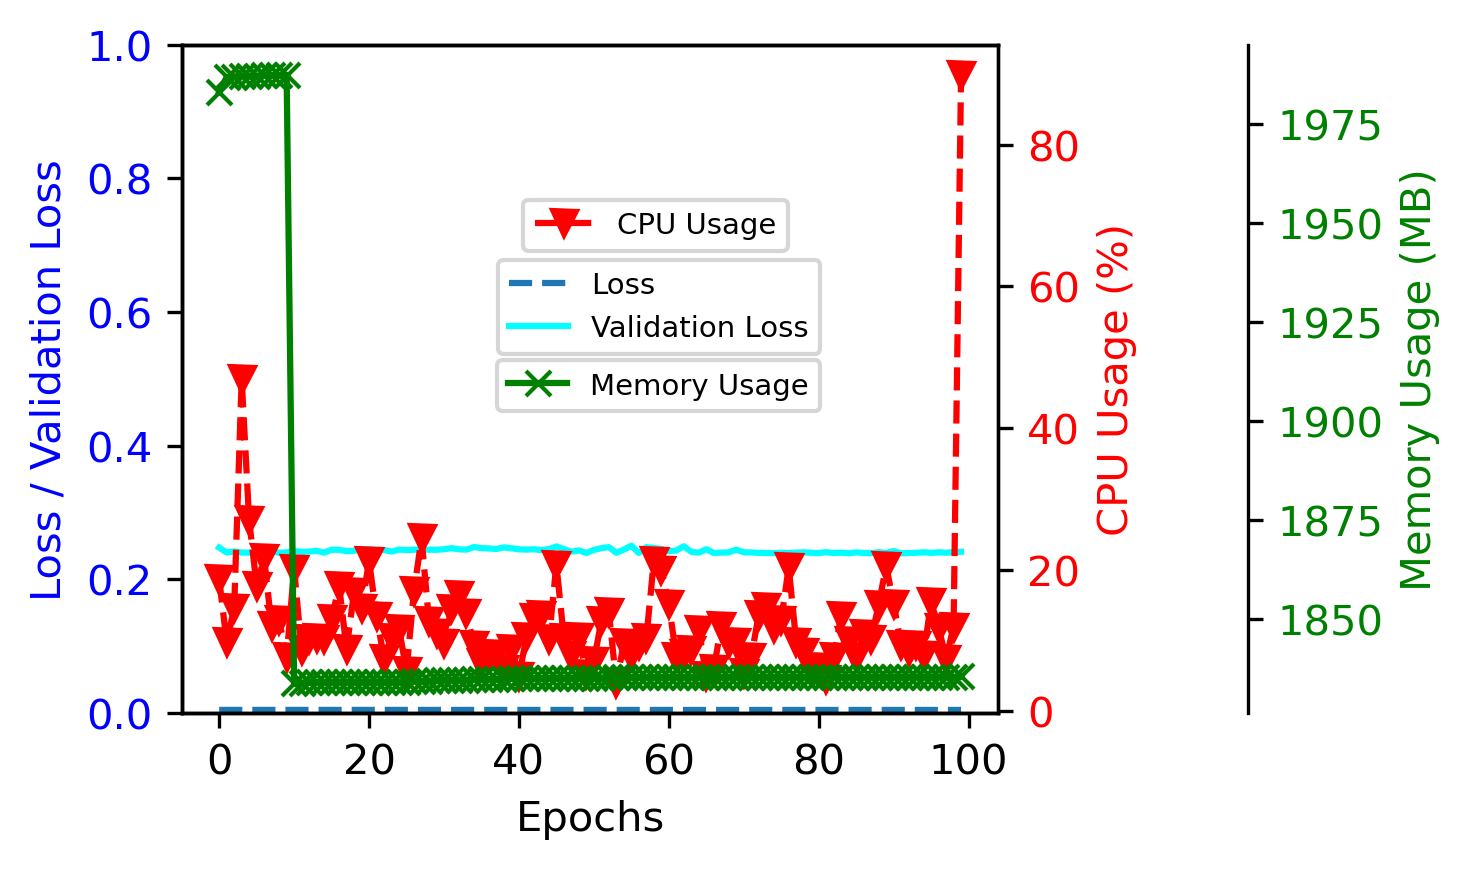

In [23]:
cpu=[18.6, 9.8, 14.5, 46.9, 27.0, 17.7, 21.6, 12.0, 12.8, 7.6, 20.1, 8.6, 10.2, 10.3, 10.2, 13.0, 17.7, 8.8, 16.8, 14.5, 21.2, 13.4, 7.4, 10.3, 11.6, 5.7, 17.0, 24.4, 12.7, 11.1, 9.6, 14.4, 16.4, 13.9, 9.3, 6.8, 7.8, 8.0, 5.9, 8.8, 5.0, 10.4, 13.1, 13.6, 10.2, 20.7, 10.3, 7.9, 10.4, 5.2, 7.1, 12.7, 14.0, 4.0, 9.6, 7.9, 9.3, 10.3, 21.2, 20.0, 15.1, 7.7, 8.1, 8.6, 11.5, 5.0, 6.0, 12.0, 9.6, 9.8, 5.4, 7.7, 13.6, 14.7, 11.7, 12.9, 20.3, 9.8, 8.4, 6.1, 6.2, 4.6, 7.7, 13.4, 9.9, 7.6, 10.9, 10.2, 15.0, 20.5, 15.2, 9.3, 8.5, 9.4, 7.9, 15.4, 11.8, 7.4, 11.9, 89.9]
mu=[1982.96484375, 1986.81640625, 1986.9375, 1987.12890625, 1987.1640625, 1987.1875, 1987.234375, 1987.265625, 1987.34765625, 1987.36328125, 1833.76953125, 1833.828125, 1833.84765625, 1833.921875, 1833.93359375, 1833.99609375, 1834.01953125, 1834.015625, 1834.02734375, 1834.04296875, 1834.0390625, 1834.0390625, 1834.0390625, 1834.04296875, 1834.05859375, 1834.046875, 1834.203125, 1834.23046875, 1834.26171875, 1834.44921875, 1834.47265625, 1834.515625, 1834.5234375, 1834.515625, 1834.65234375, 1834.67578125, 1834.71875, 1834.7421875, 1834.7578125, 1834.8671875, 1834.87109375, 1834.87890625, 1834.87109375, 1834.91796875, 1834.92578125, 1834.9765625, 1834.96484375, 1834.9765625, 1835.00390625, 1835.00390625, 1835.0546875, 1835.05859375, 1835.125, 1835.1328125, 1835.1328125, 1835.1328125, 1835.1328125, 1835.125, 1835.125, 1835.16015625, 1835.16796875, 1835.171875, 1835.203125, 1835.20703125, 1835.20703125, 1835.19921875, 1835.23046875, 1835.234375, 1835.2421875, 1835.2265625, 1835.22265625, 1835.21875, 1835.21875, 1835.234375, 1835.23828125, 1835.23828125, 1835.25, 1835.2578125, 1835.25, 1835.25390625, 1835.2421875, 1835.265625, 1835.26953125, 1835.26953125, 1835.2578125, 1835.265625, 1835.27734375, 1835.28515625, 1835.2734375, 1835.28515625, 1835.27734375, 1835.28515625, 1835.2890625, 1835.29296875, 1835.2890625, 1835.29296875, 1835.30078125, 1835.29296875, 1835.29296875, 1835.37109375]
loss=[0.004845299292355776, 0.004836448933929205, 0.004850898869335651, 0.0048412601463496685, 0.004848199430853128, 0.004836783744394779, 0.004841289948672056, 0.004868204705417156, 0.00483194924890995, 0.004838981200009584, 0.004820938687771559, 0.0048376997001469135, 0.004848160780966282, 0.004834634717553854, 0.004840825218707323, 0.004827110096812248, 0.004837716463953257, 0.004829262383282185, 0.004832983948290348, 0.004839021246880293, 0.0048433938063681126, 0.004833131562918425, 0.004819411784410477, 0.004815686959773302, 0.004818048793822527, 0.004806931596249342, 0.0048224907368421555, 0.0048275599256157875, 0.004797971807420254, 0.0048131393268704414, 0.004835357889533043, 0.004820776637643576, 0.004794666077941656, 0.004816257860511541, 0.004818630404770374, 0.0048175835981965065, 0.004814973566681147, 0.0048009250313043594, 0.004811216611415148, 0.00480143167078495, 0.004813570529222488, 0.0048127733170986176, 0.0047959135845303535, 0.004806045908480883, 0.004790918901562691, 0.004811122082173824, 0.004794354550540447, 0.004806295037269592, 0.00480410922318697, 0.004798154346644878, 0.004799370188266039, 0.004799814894795418, 0.004793180152773857, 0.004795824643224478, 0.004797342699021101, 0.004794965032488108, 0.004792206920683384, 0.004788165912032127, 0.004790423437952995, 0.0047994088381528854, 0.004811432678252459, 0.0047788615338504314, 0.0048017604276537895, 0.004788130521774292, 0.004785284865647554, 0.004784403834491968, 0.00479061808437109, 0.004787817597389221, 0.004795235116034746, 0.004786232486367226, 0.004780542571097612, 0.004790117964148521, 0.0047798557206988335, 0.0047648935578763485, 0.004796883556991816, 0.004766062367707491, 0.004790411330759525, 0.004781506489962339, 0.004766769707202911, 0.004759681411087513, 0.004769003018736839, 0.004765003453940153, 0.004771205596625805, 0.004780157003551722, 0.004764345940202475, 0.004784842953085899, 0.004781702999025583, 0.004767193924635649, 0.004793481435626745, 0.004771291743963957, 0.0047807577066123486, 0.004784850869327784, 0.004781822673976421, 0.004782408010214567, 0.004787661600857973, 0.00477235671132803, 0.004763179924339056, 0.004768241196870804, 0.004780538380146027, 0.004780216608196497]
vl=[0.24759040772914886, 0.24032250046730042, 0.24179832637310028, 0.24022774398326874, 0.2401120960712433, 0.24020624160766602, 0.2401658296585083, 0.2420523762702942, 0.23984934389591217, 0.2404155135154724, 0.24234439432621002, 0.24120409786701202, 0.24163134396076202, 0.2428113967180252, 0.24016134440898895, 0.24426323175430298, 0.24437937140464783, 0.24227476119995117, 0.24297961592674255, 0.24523255228996277, 0.244672492146492, 0.24410471320152283, 0.2439759075641632, 0.2416515201330185, 0.2446887195110321, 0.24382361769676208, 0.24447399377822876, 0.24474887549877167, 0.244414284825325, 0.24433526396751404, 0.24512739479541779, 0.24672527611255646, 0.2450409084558487, 0.2445637434720993, 0.24841341376304626, 0.24684198200702667, 0.2463761270046234, 0.24549978971481323, 0.24784421920776367, 0.2466406226158142, 0.2450357973575592, 0.24458889663219452, 0.24512454867362976, 0.24395988881587982, 0.24528531730175018, 0.24938221275806427, 0.24536289274692535, 0.24157030880451202, 0.24343903362751007, 0.23964008688926697, 0.24400834739208221, 0.24680788815021515, 0.24824392795562744, 0.23987260460853577, 0.24467499554157257, 0.2504327893257141, 0.23961830139160156, 0.24825896322727203, 0.24701549112796783, 0.2455279678106308, 0.2422288954257965, 0.24324168264865875, 0.24956433475017548, 0.2412787675857544, 0.24005870521068573, 0.24515314400196075, 0.23954971134662628, 0.24010534584522247, 0.2404431253671646, 0.24457475543022156, 0.24058377742767334, 0.2402907907962799, 0.239711195230484, 0.23945993185043335, 0.2392762005329132, 0.23986217379570007, 0.2394823580980301, 0.24011677503585815, 0.24056625366210938, 0.23987460136413574, 0.23934777081012726, 0.24077673256397247, 0.23947419226169586, 0.23999518156051636, 0.23903362452983856, 0.24035927653312683, 0.2395525425672531, 0.2393222600221634, 0.24075767397880554, 0.23961877822875977, 0.24239510297775269, 0.23907555639743805, 0.23959682881832123, 0.2398214489221573, 0.24058273434638977, 0.23971675336360931, 0.2405664473772049, 0.23991498351097107, 0.24084454774856567, 0.24134764075279236]

import pandas as pd
import matplotlib.pyplot as plt
print(cpu)
print(mu)
print(loss)
print(vl)


fig, ax1 = plt.subplots(figsize=(5, 3),dpi=300)

# First Y-axis (Loss values)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss / Validation Loss", color='blue')
ax1.plot(loss, label="Loss", color='tab:blue', linestyle='dashed')
ax1.plot(vl, label="Validation Loss", color='cyan', linestyle='solid')
ax1.tick_params(axis='y', labelcolor='blue',labelsize = 10)
ax1.set_ylim(0,1)


# Second Y-axis (CPU Usage) on the right
ax2 = ax1.twinx()
ax2.set_ylabel("CPU Usage (%)", color='red')
ax2.plot(cpu, label="CPU Usage", color='red', linestyle='dashed', marker='v')
ax2.tick_params(axis='y', labelcolor='red',labelsize = 10)

# Third Y-axis (Memory Usage) on the right, but placed slightly shifted
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift memory usage axis to avoid overlap
ax3.set_ylabel("Memory Usage (MB)", color='Green')
ax3.plot(mu, label="Memory Usage", color='Green', linestyle='solid', marker='x')
ax3.tick_params(axis='y', labelcolor='Green',labelsize = 10)

# Legends
ax1.legend(bbox_to_anchor=(0.8, 0.7), fontsize=7)
ax2.legend(bbox_to_anchor=(0.76, 0.79), fontsize=7)
ax3.legend(bbox_to_anchor=(0.8, 0.55), fontsize=7)
plt.tight_layout()

plt.savefig('2DNNMEn_allResocue.jpg')


[18.6, 9.8, 14.5, 46.9, 27.0, 17.7, 21.6, 12.0, 12.8, 7.6, 20.1, 8.6, 10.2, 10.3, 10.2, 13.0, 17.7, 8.8, 16.8, 14.5, 21.2, 13.4, 7.4, 10.3, 11.6, 5.7, 17.0, 24.4, 12.7, 11.1, 9.6, 14.4, 16.4, 13.9, 9.3, 6.8, 7.8, 8.0, 5.9, 8.8, 5.0, 10.4, 13.1, 13.6, 10.2, 20.7, 10.3, 7.9, 10.4, 5.2, 7.1, 12.7, 14.0, 4.0, 9.6, 7.9, 9.3, 10.3, 21.2, 20.0, 15.1, 7.7, 8.1, 8.6, 11.5, 5.0, 6.0, 12.0, 9.6, 9.8, 5.4, 7.7, 13.6, 14.7, 11.7, 12.9, 20.3, 9.8, 8.4, 6.1, 6.2, 4.6, 7.7, 13.4, 9.9, 7.6, 10.9, 10.2, 15.0, 20.5, 15.2, 9.3, 8.5, 9.4, 7.9, 15.4, 11.8, 7.4, 11.9, 89.9]
[1982.96484375, 1986.81640625, 1986.9375, 1987.12890625, 1987.1640625, 1987.1875, 1987.234375, 1987.265625, 1987.34765625, 1987.36328125, 1833.76953125, 1833.828125, 1833.84765625, 1833.921875, 1833.93359375, 1833.99609375, 1834.01953125, 1834.015625, 1834.02734375, 1834.04296875, 1834.0390625, 1834.0390625, 1834.0390625, 1834.04296875, 1834.05859375, 1834.046875, 1834.203125, 1834.23046875, 1834.26171875, 1834.44921875, 1834.47265625, 18

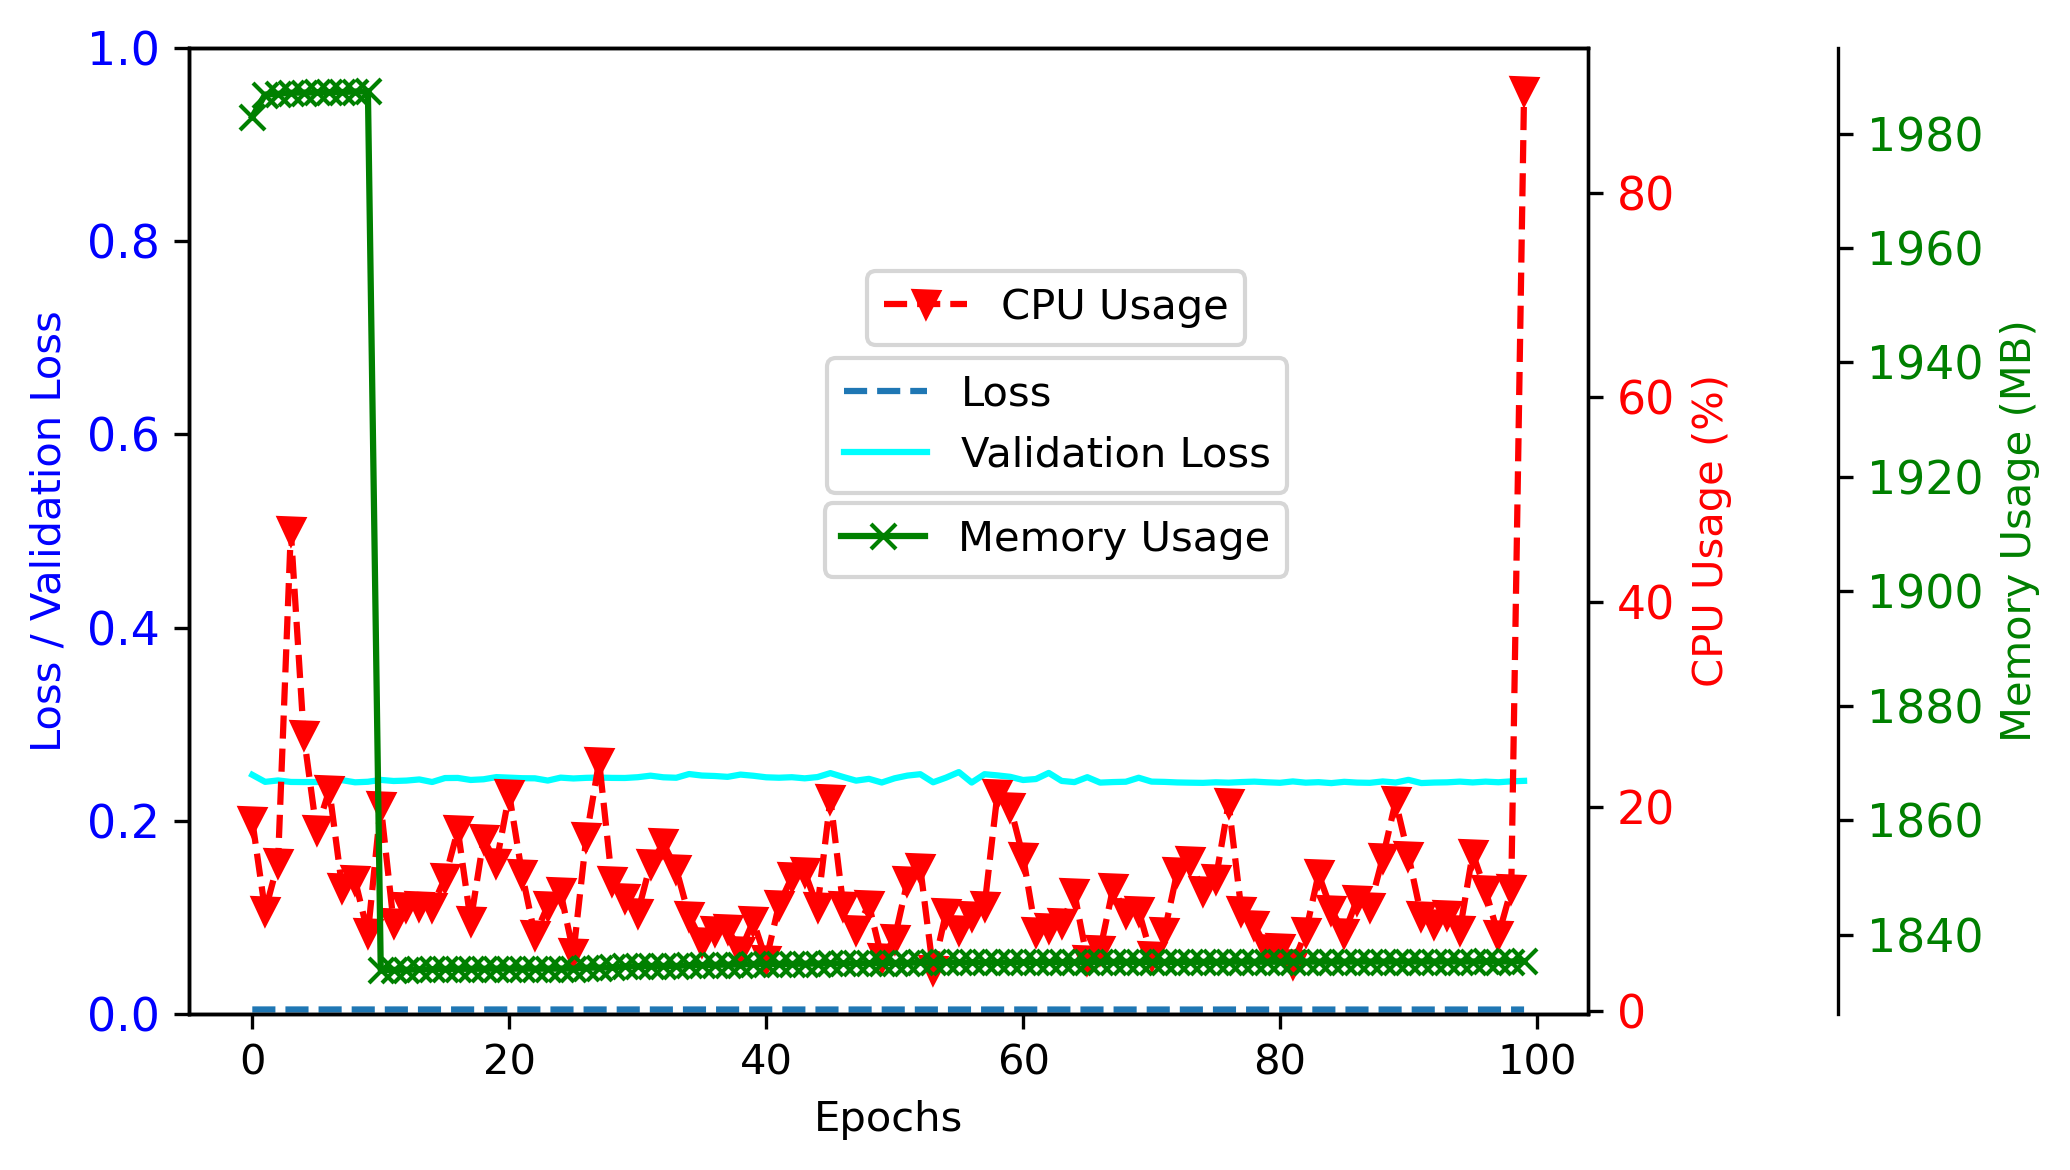

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
print(cpuusage)
print(memoryusage)
print(history.history['loss'])
print(history.history['val_loss'])


fig, ax1 = plt.subplots(figsize=(7, 4),dpi=300)

# First Y-axis (Loss values)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss / Validation Loss", color='blue')
ax1.plot(history.history['loss'], label="Loss", color='tab:blue', linestyle='dashed')
ax1.plot(history.history['val_loss'], label="Validation Loss", color='cyan', linestyle='solid')
ax1.tick_params(axis='y', labelcolor='blue',labelsize = 11)
ax1.set_ylim(0,1)


# Second Y-axis (CPU Usage) on the right
ax2 = ax1.twinx()
ax2.set_ylabel("CPU Usage (%)", color='red')
ax2.plot(cpuusage, label="CPU Usage", color='red', linestyle='dashed', marker='v')
ax2.tick_params(axis='y', labelcolor='red',labelsize = 11)

# Third Y-axis (Memory Usage) on the right, but placed slightly shifted
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift memory usage axis to avoid overlap
ax3.set_ylabel("Memory Usage (MB)", color='Green')
ax3.plot(memoryusage, label="Memory Usage", color='Green', linestyle='solid', marker='x')
ax3.tick_params(axis='y', labelcolor='Green',labelsize = 11)

# Legends
ax1.legend(bbox_to_anchor=(0.8,0.7))
ax2.legend(bbox_to_anchor=(0.77,0.79))
ax3.legend(bbox_to_anchor=(0.8,0.55))
plt.tight_layout()

plt.savefig('2DNNMEn_allResocue.jpg')


reconstruction_error tf.Tensor([0.01594816 0.00913107 0.01374132 ... 0.13540813 0.13257834 0.18522511], shape=(406377,), dtype=float64)
      error  y_true
0  0.015948       0
1  0.009131       0
2  0.013741       0
3  0.042417       0
4  0.012593       0
Threshold: 0.0043	Accuracy: 0.635		Precision: 0.817	Recall Score: 0.500
Threshold: 0.0102	Accuracy: 0.734		Precision: 0.851	Recall Score: 0.636
Threshold: 0.0125	Accuracy: 0.833		Precision: 0.894	Recall Score: 0.772
Threshold: 0.0173	Accuracy: 0.933		Precision: 0.951	Recall Score: 0.908
Threshold: 0.1249	Accuracy: 0.965		Precision: 0.956	Recall Score: 0.972
Threshold: 0.1303	Accuracy: 0.865		Precision: 0.865	Recall Score: 0.894
Threshold: 0.1341	Accuracy: 0.765		Precision: 0.804	Recall Score: 0.815
Threshold: 0.1393	Accuracy: 0.665		Precision: 0.761	Recall Score: 0.736
Threshold: 0.1835	Accuracy: 0.565		Precision: 0.728	Recall Score: 0.657
Threshold: 0.2190	Accuracy: 0.465		Precision: 0.703	Recall Score: 0.579
Threshold with Maximum R

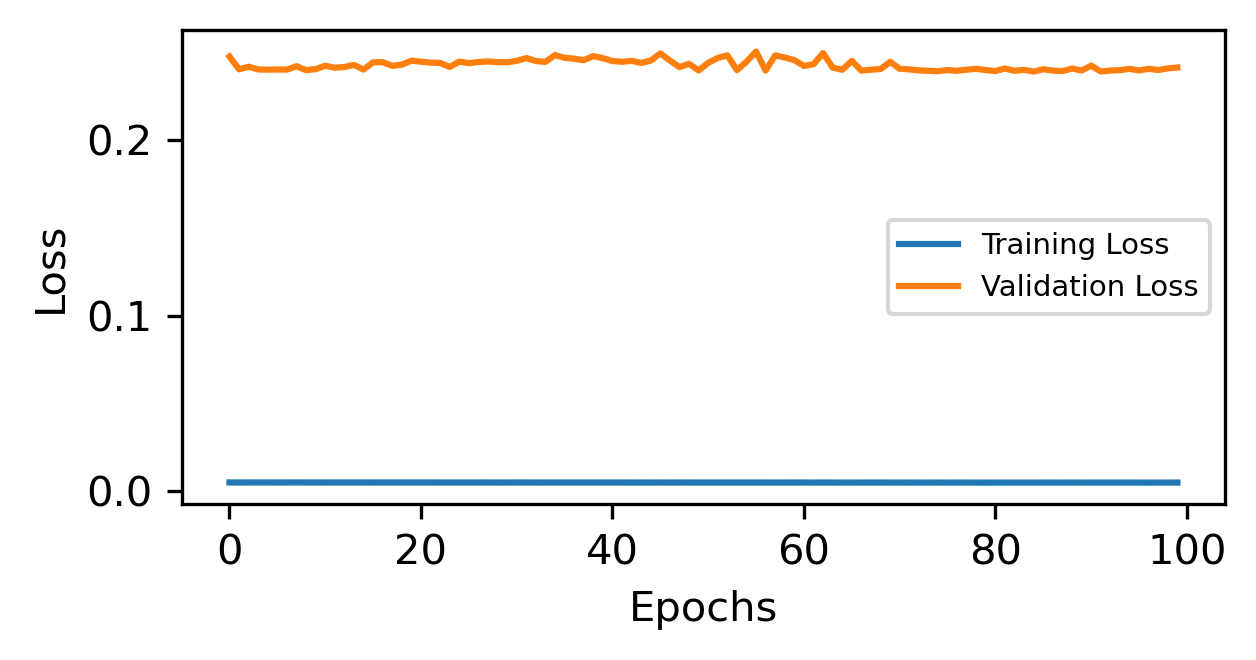

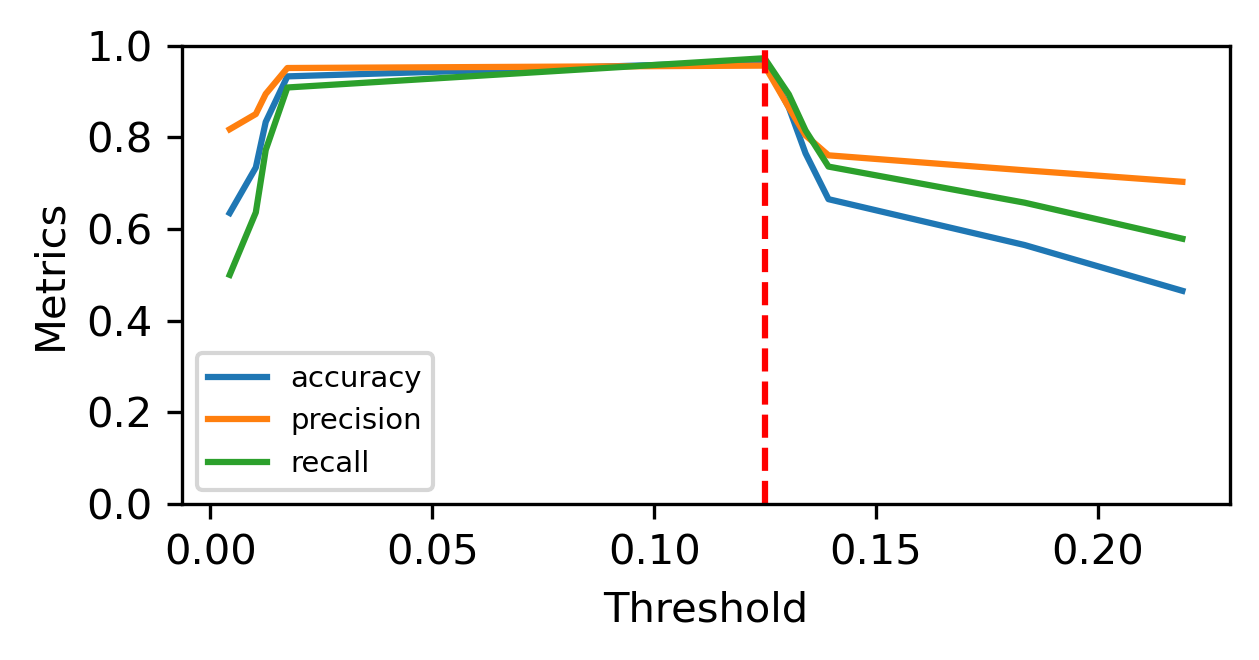

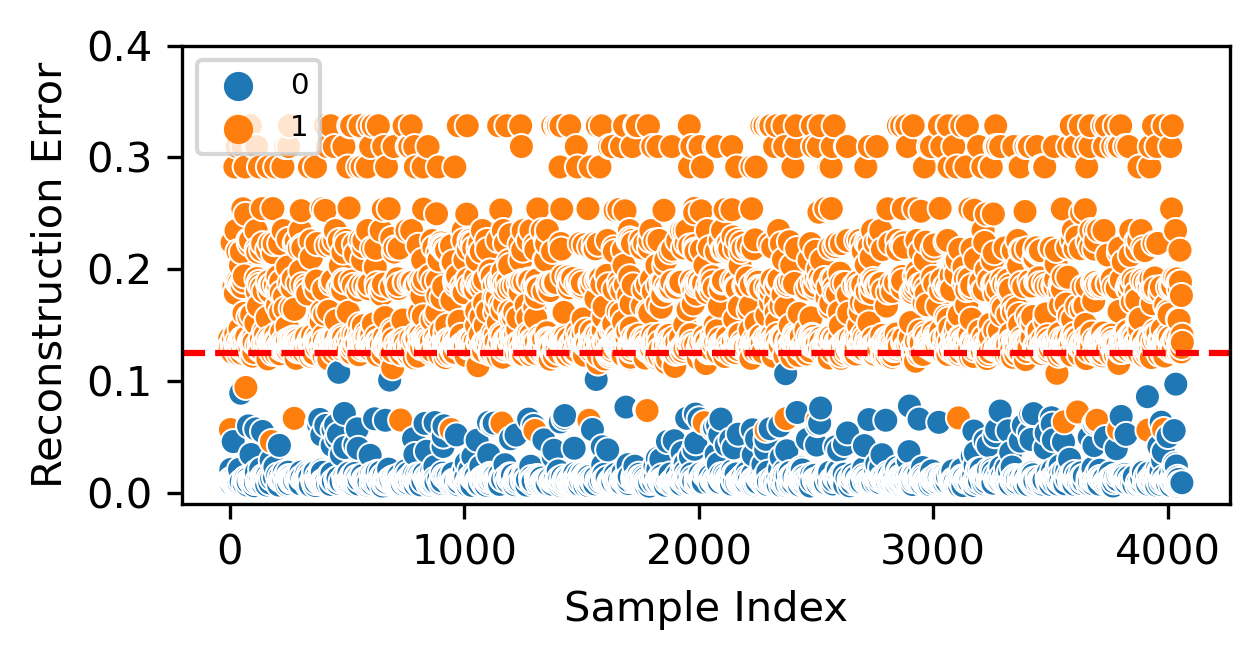

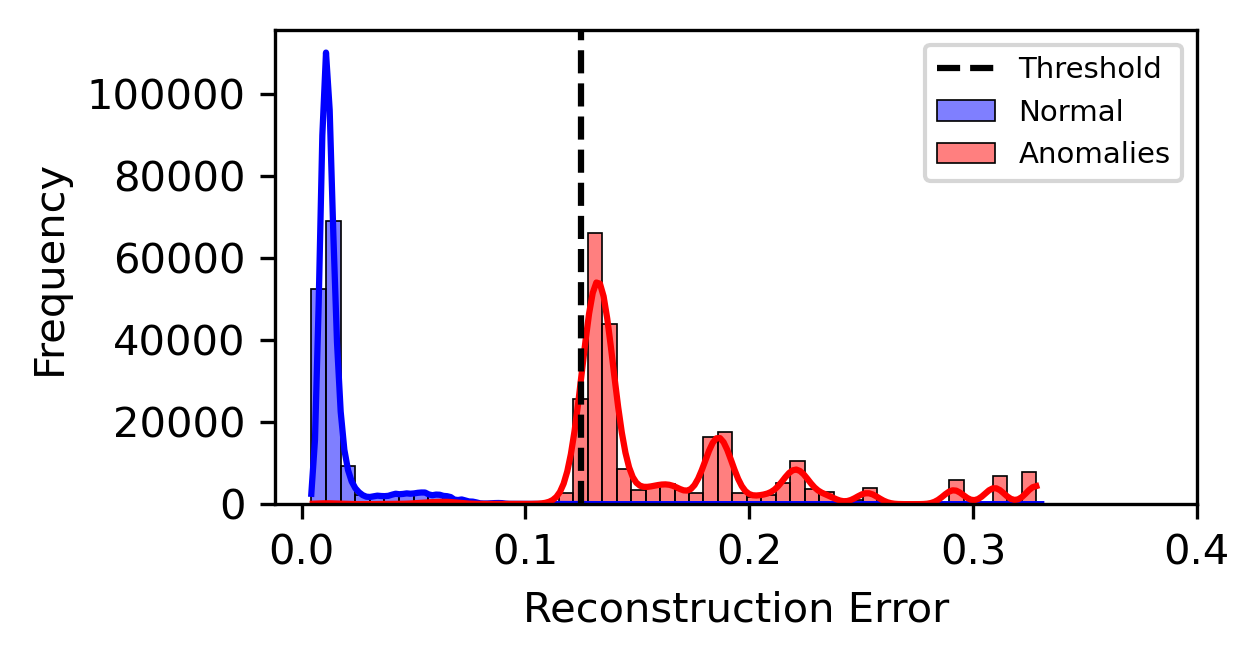

In [87]:
plt.figure(figsize=(4,2),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 7)
plt.tight_layout()
plt.tight_layout(pad=0)
plt.savefig('2DNNMEn.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(4,2),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.yticks(np.arange(0, 1.2, 0.2))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('2DNNMEn_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(4,2),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.yticks(np.arange(0, 0.5, 0.1))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('2DNNMEn_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(4,2),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 0.5, 0.1))  # Corrected method
plt.yticks(range(0, 120000, 20000))  # Correct method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('2DNNMEn_Reconst.jpg')


# CNN Model

In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D
from tensorflow.keras.optimizers import Adam

cpuusage=[]
memoryusage=[]

# Define the CNN-based Autoencoder for 1D data
def create_cnn_autoencoder_1d(input_shape):
    # Encoder
    input_layer = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    
    # Latent space
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    
    # Decoder
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Crop the output to match the input shape
    x = Cropping1D(cropping=(1, 1))(x)  # Adjust cropping as needed
    output_layer = x
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Input data shape
input_shape = (38, 1)  # 38 features with 1 channel

# Create the model
autoencoder = create_cnn_autoencoder_1d(input_shape)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")



Epoch 1/100
Epoch 1: CPU Usage: 25.50000% | Memory Usage: 1881.66016 MB
4638/4638 - 59s - 13ms/step - loss: 0.0044 - val_loss: 0.1523
Epoch 2/100
Epoch 2: CPU Usage: 15.50000% | Memory Usage: 1882.69141 MB
4638/4638 - 65s - 14ms/step - loss: 7.2667e-05 - val_loss: 0.1349
Epoch 3/100
Epoch 3: CPU Usage: 37.70000% | Memory Usage: 1835.23047 MB
4638/4638 - 61s - 13ms/step - loss: 4.0658e-05 - val_loss: 0.1499
Epoch 4/100
Epoch 4: CPU Usage: 18.20000% | Memory Usage: 1835.68359 MB
4638/4638 - 62s - 13ms/step - loss: 2.7239e-05 - val_loss: 0.1511
Epoch 5/100
Epoch 5: CPU Usage: 15.00000% | Memory Usage: 1836.26562 MB
4638/4638 - 59s - 13ms/step - loss: 2.0438e-05 - val_loss: 0.1514
Epoch 6/100
Epoch 6: CPU Usage: 14.90000% | Memory Usage: 1837.26172 MB
4638/4638 - 63s - 14ms/step - loss: 1.7081e-05 - val_loss: 0.1577
Epoch 7/100
Epoch 7: CPU Usage: 11.90000% | Memory Usage: 1838.04297 MB
4638/4638 - 57s - 12ms/step - loss: 1.4044e-05 - val_loss: 0.1587
Epoch 8/100
Epoch 8: CPU Usage: 15.400

In [89]:
autoencoder.save("CNN_MEN.h5")  # Saves in TensorFlow's native format

[25.5, 15.5, 37.7, 18.2, 15.0, 14.9, 11.9, 15.4, 20.9, 14.3, 11.4, 9.6, 12.4, 13.2, 17.5, 13.0, 13.4, 13.2, 22.6, 27.3, 23.1, 15.1, 12.8, 9.5, 11.7, 13.4, 20.1, 43.1, 15.3, 44.1, 12.4, 26.6, 12.5, 27.5, 7.8, 8.5, 13.3, 10.5, 11.0, 15.1, 10.5, 36.1, 10.4, 16.4, 14.7, 4.5, 13.7, 12.1, 9.5, 13.1, 8.1, 14.6, 12.1, 13.4, 4.8, 8.4, 17.9, 8.9, 8.9, 10.8, 13.1, 5.7, 13.2, 11.4, 6.4, 6.5, 8.7, 8.8, 12.4, 17.1, 6.1, 7.8, 12.2, 8.7, 17.7, 24.9, 13.7, 11.4, 9.2, 7.9, 9.5, 16.5, 7.9, 20.9, 30.7, 11.4, 7.5, 19.9, 20.1, 33.5, 31.2, 12.3, 11.4, 12.1, 7.4, 18.0, 11.4, 8.4, 11.1, 12.6]
[1881.66015625, 1882.69140625, 1835.23046875, 1835.68359375, 1836.265625, 1837.26171875, 1838.04296875, 1838.390625, 1838.7265625, 1839.2890625, 1840.16796875, 1840.63671875, 1684.1640625, 1684.67578125, 1685.41796875, 1686.1328125, 1686.12890625, 1686.171875, 1686.3828125, 1686.43359375, 1686.89453125, 1686.9296875, 1687.2265625, 1687.74609375, 1688.25390625, 1688.25390625, 1688.2734375, 1688.2734375, 1688.296875, 1688.5

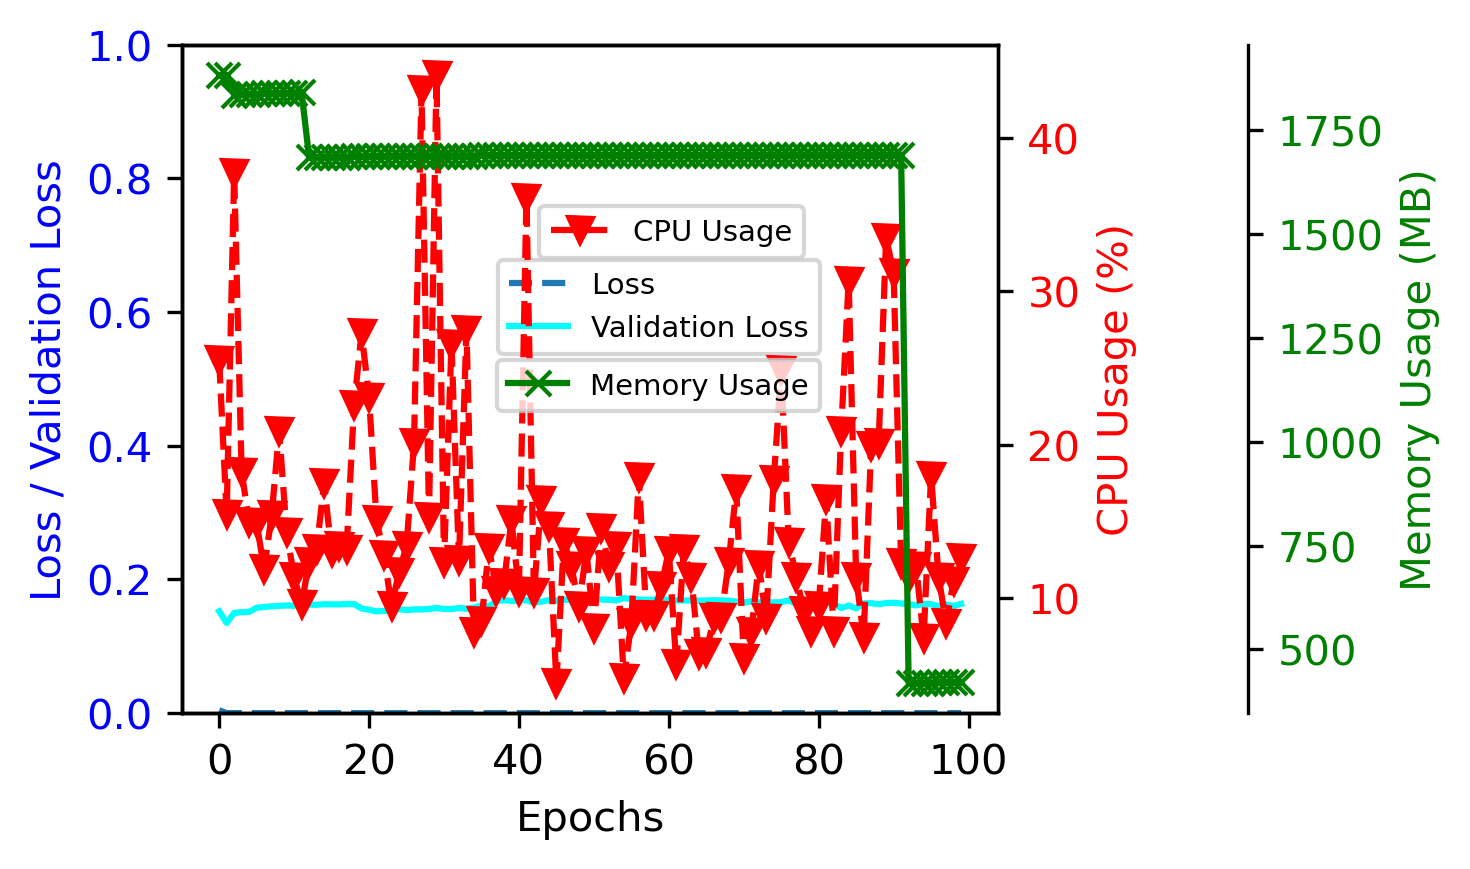

In [37]:
cpu=[25.5, 15.5, 37.7, 18.2, 15.0, 14.9, 11.9, 15.4, 20.9, 14.3, 11.4, 9.6, 12.4, 13.2, 17.5, 13.0, 13.4, 13.2, 22.6, 27.3, 23.1, 15.1, 12.8, 9.5, 11.7, 13.4, 20.1, 43.1, 15.3, 44.1, 12.4, 26.6, 12.5, 27.5, 7.8, 8.5, 13.3, 10.5, 11.0, 15.1, 10.5, 36.1, 10.4, 16.4, 14.7, 4.5, 13.7, 12.1, 9.5, 13.1, 8.1, 14.6, 12.1, 13.4, 4.8, 8.4, 17.9, 8.9, 8.9, 10.8, 13.1, 5.7, 13.2, 11.4, 6.4, 6.5, 8.7, 8.8, 12.4, 17.1, 6.1, 7.8, 12.2, 8.7, 17.7, 24.9, 13.7, 11.4, 9.2, 7.9, 9.5, 16.5, 7.9, 20.9, 30.7, 11.4, 7.5, 19.9, 20.1, 33.5, 31.2, 12.3, 11.4, 12.1, 7.4, 18.0, 11.4, 8.4, 11.1, 12.6]
mu=[1881.66015625, 1882.69140625, 1835.23046875, 1835.68359375, 1836.265625, 1837.26171875, 1838.04296875, 1838.390625, 1838.7265625, 1839.2890625, 1840.16796875, 1840.63671875, 1684.1640625, 1684.67578125, 1685.41796875, 1686.1328125, 1686.12890625, 1686.171875, 1686.3828125, 1686.43359375, 1686.89453125, 1686.9296875, 1687.2265625, 1687.74609375, 1688.25390625, 1688.25390625, 1688.2734375, 1688.2734375, 1688.296875, 1688.5625, 1688.5546875, 1688.63671875, 1688.63671875, 1688.62109375, 1688.625, 1688.84375, 1688.87890625, 1688.921875, 1688.91796875, 1688.94140625, 1688.94140625, 1688.94140625, 1688.953125, 1689.19921875, 1689.22265625, 1689.2265625, 1689.2109375, 1689.21484375, 1689.23046875, 1689.23828125, 1689.23828125, 1689.234375, 1689.234375, 1689.234375, 1689.23828125, 1689.2734375, 1689.28515625, 1689.28515625, 1689.53515625, 1689.53515625, 1689.6328125, 1689.6328125, 1689.859375, 1689.90625, 1689.91015625, 1689.8984375, 1689.91015625, 1690.12890625, 1690.140625, 1690.16796875, 1690.203125, 1690.21484375, 1690.20703125, 1690.2109375, 1690.71484375, 1690.71484375, 1690.72265625, 1690.7421875, 1690.73046875, 1690.73046875, 1690.75, 1690.75, 1690.7578125, 1690.7578125, 1690.78125, 1690.78515625, 1690.78125, 1690.78125, 1690.78125, 1690.77734375, 1690.78125, 1690.77734375, 419.82421875, 420.1640625, 420.26953125, 420.43359375, 420.86328125, 421.31640625, 421.49609375, 421.6015625]
loss=[0.004351440817117691, 7.266660395544022e-05, 4.0657887439010665e-05, 2.7238826078246348e-05, 2.0437944840523414e-05, 1.708057607174851e-05, 1.404388967785053e-05, 1.2853530279244296e-05, 1.1133124644402415e-05, 1.037086985888891e-05, 9.449143362871837e-06, 8.722392522031441e-06, 8.350069947482552e-06, 7.845325853850227e-06, 7.197227205324452e-06, 6.9142788561293855e-06, 6.458903499151347e-06, 6.114682491897838e-06, 5.913803306611953e-06, 5.536528988159262e-06, 5.35872595719411e-06, 5.211748430156149e-06, 4.900321528111817e-06, 4.79322579849395e-06, 4.6738000492041465e-06, 4.485884801397333e-06, 4.304740741645219e-06, 4.255975454725558e-06, 4.1707721720740665e-06, 4.0845739022188354e-06, 3.880856183968717e-06, 3.980887413490564e-06, 3.8041775951569434e-06, 3.991240646428196e-06, 3.4372574191365857e-06, 3.4729741855699103e-06, 3.4290628718736116e-06, 3.3304788757959614e-06, 3.325473471704754e-06, 3.336214376759017e-06, 3.1907957236398943e-06, 3.012692104675807e-06, 3.1483393740927568e-06, 3.0445689844782464e-06, 2.8053570986230625e-06, 2.8816357371397316e-06, 2.8456734071369283e-06, 2.760724100880907e-06, 2.866358499886701e-06, 2.704552798604709e-06, 2.5929023195203627e-06, 2.494195541657973e-06, 2.5917834136635065e-06, 2.5245769847970223e-06, 2.6727095701062353e-06, 2.386063897574786e-06, 2.3819443413231056e-06, 2.397941671006265e-06, 2.3187321858131327e-06, 2.231721964562894e-06, 2.4107619083224563e-06, 2.332711801500409e-06, 2.239962213934632e-06, 2.1805506094096927e-06, 2.104625764332013e-06, 2.13019416150928e-06, 2.0578233943524538e-06, 2.0273187146813143e-06, 1.9965962110291002e-06, 2.103701262967661e-06, 2.0215411495883018e-06, 2.0624479475372937e-06, 1.914282165671466e-06, 2.027133859883179e-06, 2.012908680626424e-06, 1.9882027118001133e-06, 1.94118797480769e-06, 1.866370439529419e-06, 1.8246033732793876e-06, 1.8354836583966971e-06, 1.7684106978776981e-06, 1.7848152538135764e-06, 1.776899807737209e-06, 1.807513285712048e-06, 1.6993410554277943e-06, 1.753900164658262e-06, 1.736437297950033e-06, 1.6305368717439706e-06, 1.6883540183698642e-06, 1.7068928173102904e-06, 1.5676356497351662e-06, 1.5976763734215638e-06, 1.6156968740688171e-06, 1.6266694728983566e-06, 1.597864979885344e-06, 1.6299929939123103e-06, 1.530165150143148e-06, 1.5563376791760675e-06, 1.5842304037505528e-06, 1.5120580201255507e-06]
vl=[0.15227679908275604, 0.13485264778137207, 0.1498630791902542, 0.15109829604625702, 0.1513781100511551, 0.15770740807056427, 0.15873372554779053, 0.1597086638212204, 0.16035312414169312, 0.1610872894525528, 0.16057614982128143, 0.16196127235889435, 0.1623859852552414, 0.16208630800247192, 0.1629355251789093, 0.162783682346344, 0.1625993251800537, 0.16320639848709106, 0.1631530225276947, 0.1564466655254364, 0.1546529084444046, 0.15228426456451416, 0.15300969779491425, 0.1534377932548523, 0.15562975406646729, 0.15414133667945862, 0.15523813664913177, 0.1549733728170395, 0.1558694839477539, 0.15729433298110962, 0.15592607855796814, 0.15577375888824463, 0.1571723073720932, 0.15603964030742645, 0.1577569842338562, 0.16107532382011414, 0.15974527597427368, 0.16747675836086273, 0.16906264424324036, 0.16787107288837433, 0.168338343501091, 0.16889029741287231, 0.1651330441236496, 0.16681069135665894, 0.1690705120563507, 0.16867560148239136, 0.1695355623960495, 0.16984446346759796, 0.1695273518562317, 0.16951687633991241, 0.16940519213676453, 0.1701030731201172, 0.16960130631923676, 0.16862402856349945, 0.1720837652683258, 0.1709144413471222, 0.1699734628200531, 0.16948367655277252, 0.16963131725788116, 0.1694222092628479, 0.16982342302799225, 0.16871817409992218, 0.16848808526992798, 0.1686905324459076, 0.16843396425247192, 0.16839148104190826, 0.16895560920238495, 0.1685205101966858, 0.16826702654361725, 0.16683845221996307, 0.16521181166172028, 0.1674969643354416, 0.16566359996795654, 0.16594894230365753, 0.16575227677822113, 0.1659025251865387, 0.16880600154399872, 0.16337595880031586, 0.1662912517786026, 0.16619643568992615, 0.1652124673128128, 0.16582468152046204, 0.16329985857009888, 0.1573365479707718, 0.16094711422920227, 0.15675637125968933, 0.16419951617717743, 0.16448111832141876, 0.16287702322006226, 0.16461773216724396, 0.16507069766521454, 0.16410429775714874, 0.16290590167045593, 0.1612941175699234, 0.16340474784374237, 0.16305434703826904, 0.15990008413791656, 0.16258873045444489, 0.16024240851402283, 0.16341924667358398]
import pandas as pd
import matplotlib.pyplot as plt
print(cpu)
print(mu)
print(loss)
print(vl)


fig, ax1 = plt.subplots(figsize=(5, 3),dpi=300)

# First Y-axis (Loss values)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss / Validation Loss", color='blue')
ax1.plot(loss, label="Loss", color='tab:blue', linestyle='dashed')
ax1.plot(vl, label="Validation Loss", color='cyan', linestyle='solid')
ax1.tick_params(axis='y', labelcolor='blue',labelsize = 10)
ax1.set_ylim(0,1)


# Second Y-axis (CPU Usage) on the right
ax2 = ax1.twinx()
ax2.set_ylabel("CPU Usage (%)", color='red')
ax2.plot(cpu, label="CPU Usage", color='red', linestyle='dashed', marker='v')
ax2.tick_params(axis='y', labelcolor='red',labelsize = 10)

# Third Y-axis (Memory Usage) on the right, but placed slightly shifted
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift memory usage axis to avoid overlap
ax3.set_ylabel("Memory Usage (MB)", color='Green')
ax3.plot(mu, label="Memory Usage", color='Green', linestyle='solid', marker='x')
ax3.tick_params(axis='y', labelcolor='Green',labelsize = 10)

# Legends
ax1.legend(bbox_to_anchor=(0.8, 0.7), fontsize=7)
ax2.legend(bbox_to_anchor=(0.42, 0.78), fontsize=7)
ax3.legend(bbox_to_anchor=(0.8, 0.55), fontsize=7)
plt.tight_layout()

plt.savefig('con1dMEn_allResocue.jpg')


[25.5, 15.5, 37.7, 18.2, 15.0, 14.9, 11.9, 15.4, 20.9, 14.3, 11.4, 9.6, 12.4, 13.2, 17.5, 13.0, 13.4, 13.2, 22.6, 27.3, 23.1, 15.1, 12.8, 9.5, 11.7, 13.4, 20.1, 43.1, 15.3, 44.1, 12.4, 26.6, 12.5, 27.5, 7.8, 8.5, 13.3, 10.5, 11.0, 15.1, 10.5, 36.1, 10.4, 16.4, 14.7, 4.5, 13.7, 12.1, 9.5, 13.1, 8.1, 14.6, 12.1, 13.4, 4.8, 8.4, 17.9, 8.9, 8.9, 10.8, 13.1, 5.7, 13.2, 11.4, 6.4, 6.5, 8.7, 8.8, 12.4, 17.1, 6.1, 7.8, 12.2, 8.7, 17.7, 24.9, 13.7, 11.4, 9.2, 7.9, 9.5, 16.5, 7.9, 20.9, 30.7, 11.4, 7.5, 19.9, 20.1, 33.5, 31.2, 12.3, 11.4, 12.1, 7.4, 18.0, 11.4, 8.4, 11.1, 12.6]
[1881.66015625, 1882.69140625, 1835.23046875, 1835.68359375, 1836.265625, 1837.26171875, 1838.04296875, 1838.390625, 1838.7265625, 1839.2890625, 1840.16796875, 1840.63671875, 1684.1640625, 1684.67578125, 1685.41796875, 1686.1328125, 1686.12890625, 1686.171875, 1686.3828125, 1686.43359375, 1686.89453125, 1686.9296875, 1687.2265625, 1687.74609375, 1688.25390625, 1688.25390625, 1688.2734375, 1688.2734375, 1688.296875, 1688.5

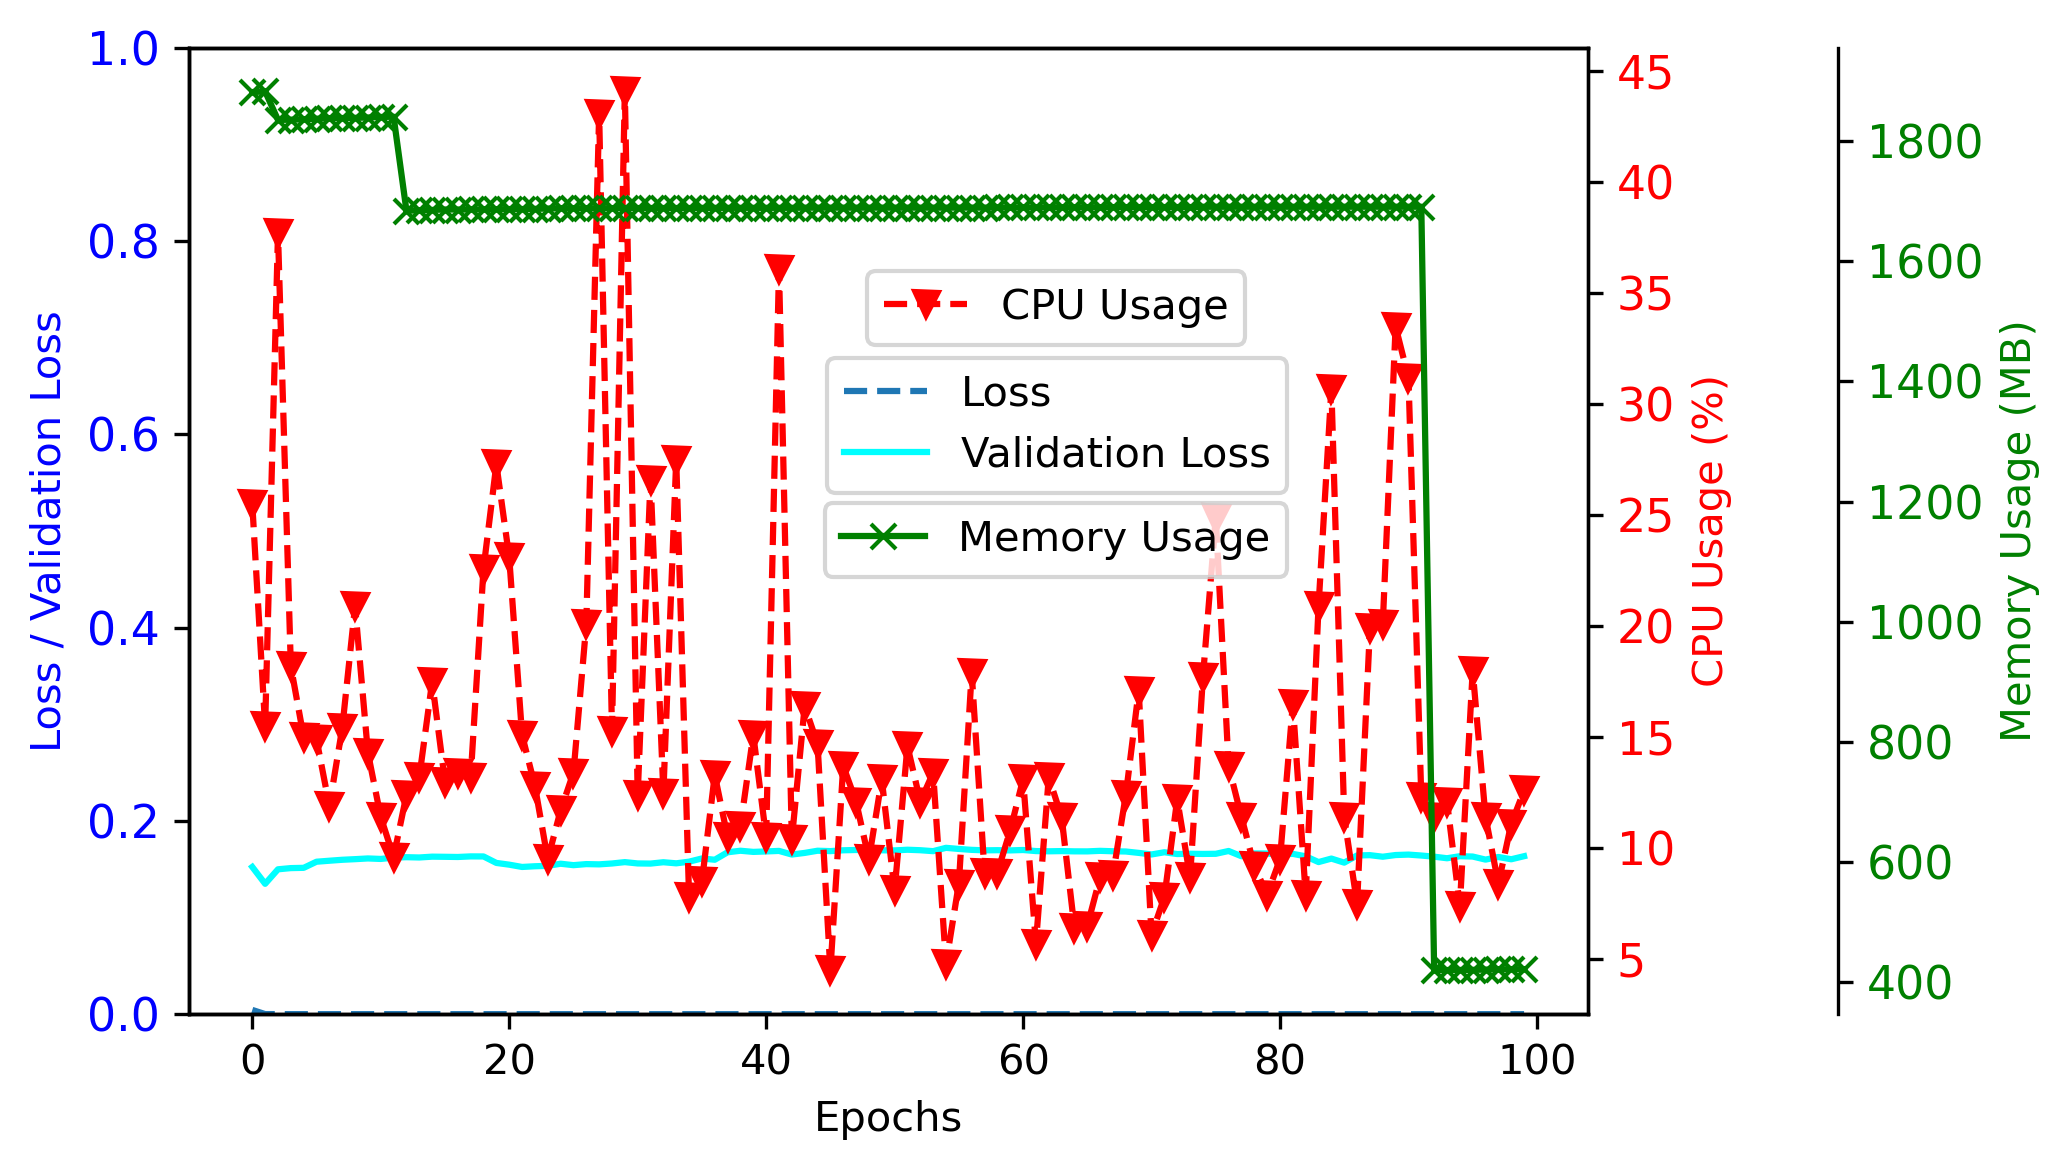

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
print(cpuusage)
print(memoryusage)
print(history.history['loss'])
print(history.history['val_loss'])


fig, ax1 = plt.subplots(figsize=(7, 4),dpi=300)

# First Y-axis (Loss values)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss / Validation Loss", color='blue')
ax1.plot(history.history['loss'], label="Loss", color='tab:blue', linestyle='dashed')
ax1.plot(history.history['val_loss'], label="Validation Loss", color='cyan', linestyle='solid')
ax1.tick_params(axis='y', labelcolor='blue',labelsize = 11)
ax1.set_ylim(0,1)


# Second Y-axis (CPU Usage) on the right
ax2 = ax1.twinx()
ax2.set_ylabel("CPU Usage (%)", color='red')
ax2.plot(cpuusage, label="CPU Usage", color='red', linestyle='dashed', marker='v')
ax2.tick_params(axis='y', labelcolor='red',labelsize = 11)

# Third Y-axis (Memory Usage) on the right, but placed slightly shifted
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Shift memory usage axis to avoid overlap
ax3.set_ylabel("Memory Usage (MB)", color='Green')
ax3.plot(memoryusage, label="Memory Usage", color='Green', linestyle='solid', marker='x')
ax3.tick_params(axis='y', labelcolor='Green',labelsize = 11)

# Legends
ax1.legend(bbox_to_anchor=(0.8,0.7))
ax2.legend(bbox_to_anchor=(0.77,0.79))
ax3.legend(bbox_to_anchor=(0.8,0.55))
plt.tight_layout()

plt.savefig('con1dMEn_allResocue.jpg')


reconstruction_error tf.Tensor([0.00053588 0.00043699 0.00046838 ... 0.19068209 0.20307682 0.20794731], shape=(406377,), dtype=float64)
      error  y_true
0  0.000536       0
1  0.000437       0
2  0.000468       0
3  0.000833       0
4  0.000312       0
Threshold: 0.0002	Accuracy: 0.635		Precision: 0.817	Recall Score: 0.500
Threshold: 0.0004	Accuracy: 0.734		Precision: 0.851	Recall Score: 0.636
Threshold: 0.0005	Accuracy: 0.833		Precision: 0.895	Recall Score: 0.772
Threshold: 0.0006	Accuracy: 0.933		Precision: 0.951	Recall Score: 0.909
Threshold: 0.0279	Accuracy: 0.963		Precision: 0.954	Recall Score: 0.971
Threshold: 0.0482	Accuracy: 0.850		Precision: 0.854	Recall Score: 0.882
Threshold: 0.1901	Accuracy: 0.765		Precision: 0.804	Recall Score: 0.815
Threshold: 0.1952	Accuracy: 0.665		Precision: 0.761	Recall Score: 0.736
Threshold: 0.1990	Accuracy: 0.565		Precision: 0.728	Recall Score: 0.658
Threshold: 0.2045	Accuracy: 0.465		Precision: 0.703	Recall Score: 0.579
Threshold with Maximum R

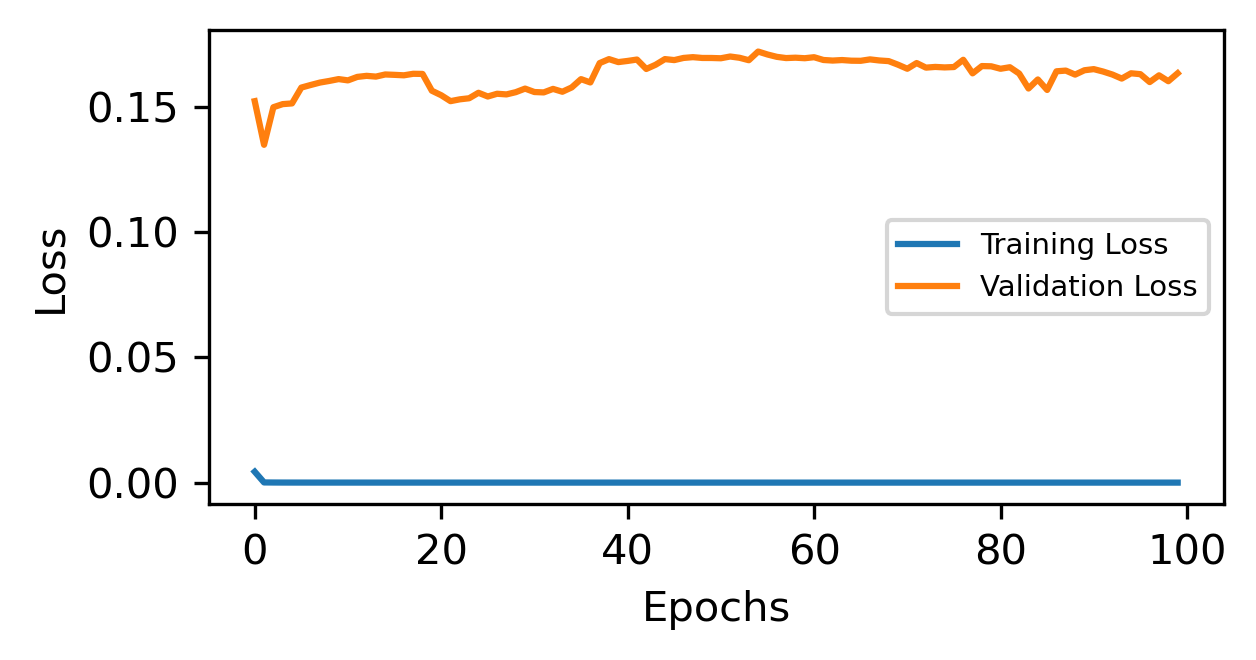

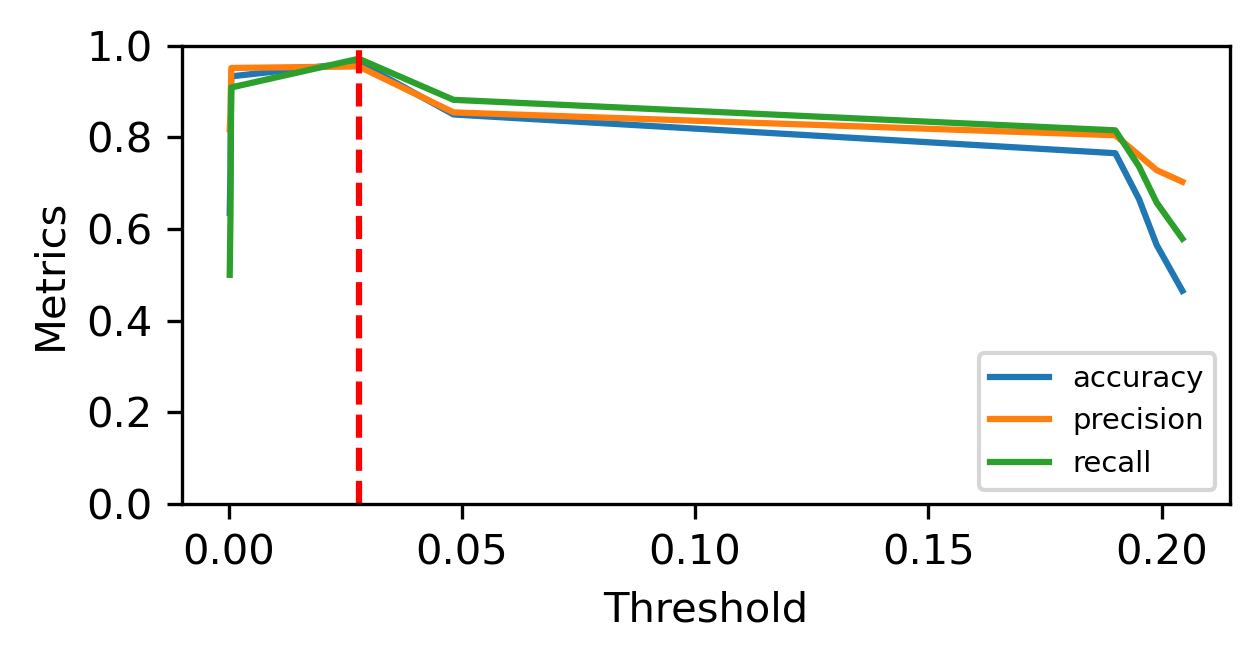

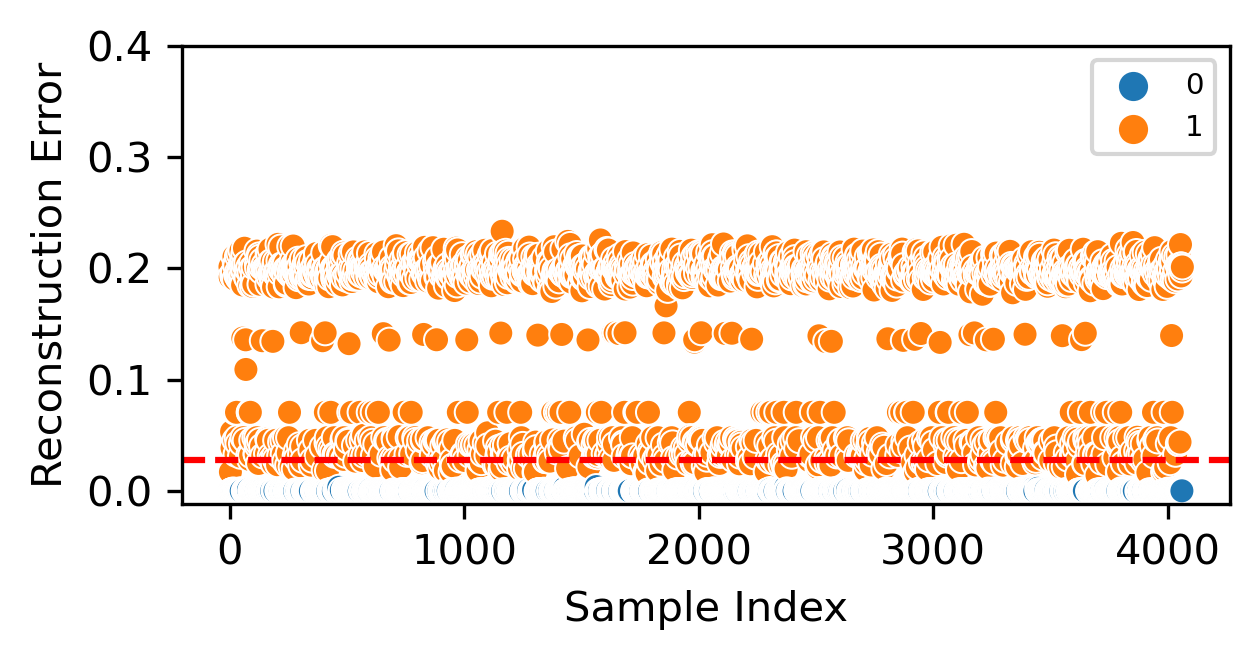

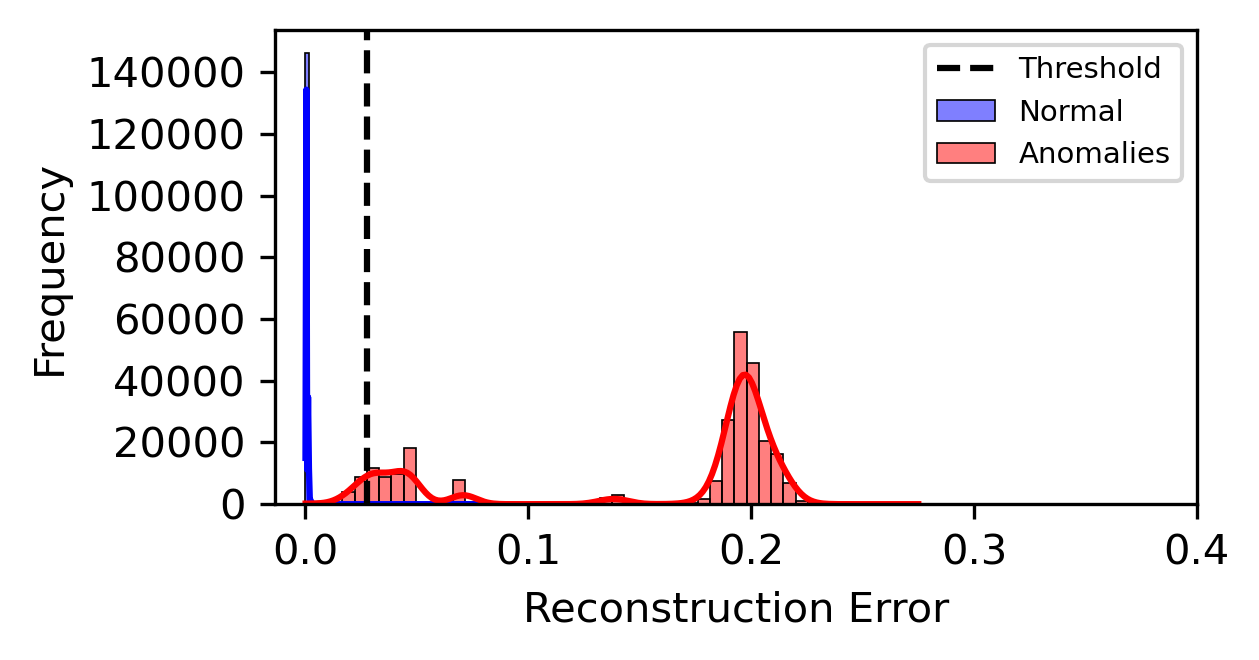

In [92]:
plt.figure(figsize=(4,2),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 7)
plt.tight_layout()
plt.tight_layout(pad=0)
plt.savefig('con1dMEn.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(4,2),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.yticks(np.arange(0, 1.2, 0.2))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dMEn_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(4,2),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.yticks(np.arange(0, 0.5, 0.1))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dMEn_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(4,2),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 0.5, 0.1))  # Corrected method
plt.yticks(range(0, 160000, 20000))  # Correct method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dMEn_Reconst.jpg')
